# Week 5 - Semantic & Influence Networks

This week, we explore the representation and analysis of semantic and influence networks. We begin by introducing you to some straightforward approaches to network analysis. We then begin to illustrate them with word networks that we can analyze to understand the structure of how words connect with one another, and the dynamics of how their meanings flow through a discursive system. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify them). Rendering words linked as a network or discrete topology allows us to take advantage of the network analysis metrics like centrality and community.

Texts also represent moves in a social game, and we can analyze the interchange of words and phrases within them in order to understand more about the relationships between people, groups and organizations that interact with one another. For example, who influences whom? And in a singular conversation--like a discussion of tweets on comments in Facebook--or over vast stretches of time (e.g., How much was Kant influenced by Aristotle? by Plato? Was _Chinatown_ director Robert Towne influenced by Sophocles?) We will do this by extracting conversational moves from text. But note that the similarity measures from last week's homework can also be used to represent a matrix of similarities--and potential influences--from one document to another. Rendering social actors or documentary events (e.g., a book) linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, and sophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity of social relations. Moreover, we can link explicit social interactions (e.g., "friendship" on Facebook, coupling in a romantic relationship, etc.) with semantic networks to better make sense of how pepole (inter)act in the world. 

For this notebook we will use the following packages:

In [8]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

# An Introduction to networks in *networkx*

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with lets create an undirected graph:

In [ ]:
g = nx.Graph()
g

We can add nodes. These are all named, like entries in a dictionary.

In [ ]:
g.add_node(1)
g.add_node(2)
g.add_node(3)

Now we have 3 vertices:

In [ ]:
len(g.nodes)

Or if we want to get more information about the graph:

In [ ]:
print(nx.info(g))

We can give nodes properties, like name or type

In [ ]:
g.nodes[1]

In [ ]:
g.nodes[1]['type'] = 'NN'

In [ ]:
g.nodes[1]

In [ ]:
g.nodes[2]['name'] = 'dog'

In [ ]:
g.nodes[2]

Still pretty boring...

Lets add a couple of edges. Notice that we use the ids, but not any of the properties:

In [ ]:
g.add_edges_from([(1, 2), (2, 3), (3, 1), (1,4)])
print(nx.info(g))

Note how the summary has changed. Moreover, there's one additional node, because we asked for an edge to 4.

We can also give the edges properties like weights:

In [ ]:
g.edges[1, 2]['weight'] = 2
g.edges[1, 4]['weight'] = 2
g.edges[1, 4]

Let's visualize our graph now:

In [ ]:
nx.draw_networkx(g)
plt.savefig("test.png")

Very exciting :-).

There are many things to do with the graph once we have created it, some of which we will explore here with a word semantic network.

First let's load some data: the Grimmer Senate press release corpus:

In [93]:
senReleasesDF = pandas.read_csv('../data/senReleasesTraining.csv', index_col = 0)
senReleasesDF[:3]

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   

                                                text targetSenator  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy

We will be extracting sentences, as well as tokenizing and stemming. (You should be able to do this in your sleep now).

In [ ]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

Let's begin by looking at words that co-occur in the same sentences:

In [321]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        # making the matrix symmetrical
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

First, build a graph based on word cooccurences in the first 100 press releases.

In [ ]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

Total number of vertices:

In [ ]:
len(g.nodes)

Total number of edges:

In [ ]:
len(g.edges)

A part of the adjacency matrix of cleaned word by press releases:

In [ ]:
nx.to_numpy_matrix(g)[:10, :10]

We can save the graph and read it later, although this is slow if there are many edges or nodes, so we will filter first, as we will demonstrate below.

In [ ]:
#nx.write_graphml(g, '../data/Obama_words.graphml')

Alternatively, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [314]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

In [315]:
import sklearn.feature_extraction
# in case we get a module not found error

In [ ]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(senReleasesDF['text'][:100])

In [ ]:
senVects_incidence.shape

We need to turn the incidence matrix into a network. Note the use of bipartite as an attribute--this is how you need to tell networkx the graph is bipartite:

In [ ]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [ ]:
print(nx.info(g_2mode))

A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding. 

Let's plot the bipartite network with a quick spring layout:

In [ ]:
plt.rcParams['figure.figsize']=(20,10)
nx.draw_networkx(g_2mode)

With no filtering, this will not bring insight (see below). If we want even faster computation and tunable visualizations, check out [Pajek](http://mrvar.fdv.uni-lj.si/pajek/) or [gephi](https://gephi.org/).

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share:

In [316]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [ ]:
gDoc = contractNetwork(g_2mode, 'doc')

Let's first take a look at the document-to-document network:

In [ ]:
print(nx.info(gDoc))

Let's construct a visualization. It is not surprising that almost every document is connected to every other. We can use edge weight to distinguish document distance (modeled as attraction):

In [ ]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Lets draw the graph with high and low weight edges distinguished:

In [ ]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 53 and 63 are on the outside, while 39 and 23 are at the center. We can look at them:

In [ ]:
print(len(senReleasesDF.iloc[63]['text']),"words:","\n",senReleasesDF.iloc[63]['text'].strip().replace('  ', '\n'))

In [ ]:
print(len(senReleasesDF.iloc[23]['text']),"words:","\n",senReleasesDF.iloc[23]['text'].strip().replace('  ', '\n'))

Ah...those documents with the **most** words are unsprisingly the most central in this simple document network.

Now let's turn it around and look at the word-to-word network by documents. 

In [ ]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

First, let's reduce the number of words to a manageable size.

In [ ]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. But without filtering, it is too large. Let's first drop all the edges with weight below 25, then drop all the isolates. You are recommended to play with the weight here to see how the graph might look different.

In [ ]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

In [ ]:
len(g)

In [ ]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 25])

In [ ]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [ ]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [ ]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

A bit smaller now, Now, let's visualize it: 

In [ ]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

Let us use this oppurtunity to introduce a concept of finding communities in graphs: a popular one is the modularity measure, introduced in: Clauset, A., Newman, M. E., & Moore, C. “Finding community structure in very large networks.” Physical Review E 70(6), 2004.

networkx implements this through the above method. It yields sets of nodes, one for each community.

In [ ]:
c

In [ ]:
len(c)

We can also remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score). Note that for this case we get the same graph; this is just to demonstrate the different kinds of node dropping and graph changes we can do.

In [ ]:
giant = nx.Graph(giant)

In [ ]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

In [ ]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can continue to trim globally to investigate the structure of words at alternative slices of network density. 

Moreover, we can find cliques, or completely connected sets of nodes. 

In [ ]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'america'. 

In [ ]:
americanNeighbors = giant.neighbors('american')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))

In [ ]:
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [ ]:
americanNeighbors = gWord.neighbors('american')
americanNeighborsPlus1 = set(americanNeighbors)
for n in americanNeighbors:
    americanNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in americanNeighborsPlus1:
#    print(x)

In [ ]:
g_american2 = giant.subgraph(americanNeighborsPlus1)
print(nx.info(g_american2))

In [ ]:
layout_amer = nx.spring_layout(g_american2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_american2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
nx.draw(g_american2, ax = ax, pos = layout_amer, labels = {n:n for n in g_american2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that give insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

In [317]:
# loading the data
my_df = pandas.read_csv('../project/cleaned-toxic-comments/train_preprocessed.csv')
my_df['tokenized_text'] = my_df['comment_text'].apply(tokenize)

In [318]:
my_insult = my_df.loc[my_df['insult'] == 1.0]
my_noninsult = my_df.loc[my_df['insult'] != 1.0]
my_insult

comment_text                id  \
6            cock  suck before you piss around on my work  0002bcb3da6cb337   
42      you are  gay  or antisemmitian archangel white...  001810bf8c45bf5f   
43               fuck your filthy mother in the ass  dry   00190820581d90ce   
55      stupid peace of  shit  stop deleting my stuff ...  0020e7119b96eeeb   
56       tony sidaway is obviously a fist  fuck  ee  h...  0020fd96ed3b8c8b   
...                                                   ...               ...   
159494   our previous conversation you fuck  ing  shit...  fef4cf7ba0012866   
159514                  you are a mischievious pubic hair  ff39a2895fc3b40e   
159541  your absurd edits your absurd edits on great w...  ffa33d3122b599d6   
159546   hey listen don t you ever  delete my edits ev...  ffb47123b2d82762   
159554  and i m going to keep posting the stuff u dele...  ffbdbb0483ed0841   

        identity_hate  insult  obscene    set  severe_toxic  threat  toxic  \
6                 0.0     1.0      1.0  train           1.0     0.0    1.0   
42                1.0     1.0      1.0  train           0.0     0.0    1.0   
43                0.0     1.0      1.0  train           0.0     0.0    1.0   
55                0.0     1.0      1.0  train           1.0     0.0    1.0   
56                0.0     1.0      1.0  train           0.0     0.0    1.0   
...               ...     ...      ...    ...           ...     ...    ...   
159494            1.0     1.0      1.0  train           0.0     0.0    1.0   
159514            0.0     1.0      0.0  train           0.0     0.0    1.0   
159541            0.0     1.0      1.0  train           0.0     0.0    1.0   
159546            0.0     1.0      0.0  train           0.0     0.0    1.0   
159554            0.0     1.0      1.0  train           0.0     0.0    1.0   

        toxicity                                     tokenized_text  
6            4.0                           [cock, suck, piss, work]  
42           4.0  [gay, antisemmitian, archangel, white, tiger, ...  
43           3.0                   [fuck, filthy, mother, ass, dry]  
55           4.0  [stupid, peace, shit, stop, delete, stuff, ass...  
56           3.0  [tony, sidaway, obviously, fist, fuck, ee, lov...  
...          ...                                                ...  
159494       4.0  [previous, conversation, fuck, ing, shit, eat,...  
159514       2.0                        [mischievious, pubic, hair]  
159541       3.0  [absurd, edit, absurd, edit, great, white, sha...  
159546       2.0  [hey, listen, don, t, delete, edit, be, annoy,...  
159554       3.0  [be, go, post, stuff, u, delete, fuck, ing, si...  

[7877 rows x 11 columns]

In [322]:
my_coword_g = wordCooccurrence(my_insult['tokenized_text'])

In [323]:
print('coword nodes:', len(my_coword_g.nodes))
print('coword edges:', len(my_coword_g.edges))

coword nodes: 15674
coword edges: 1297379


In [324]:
list(nx.isolates(my_coword_g))

[]

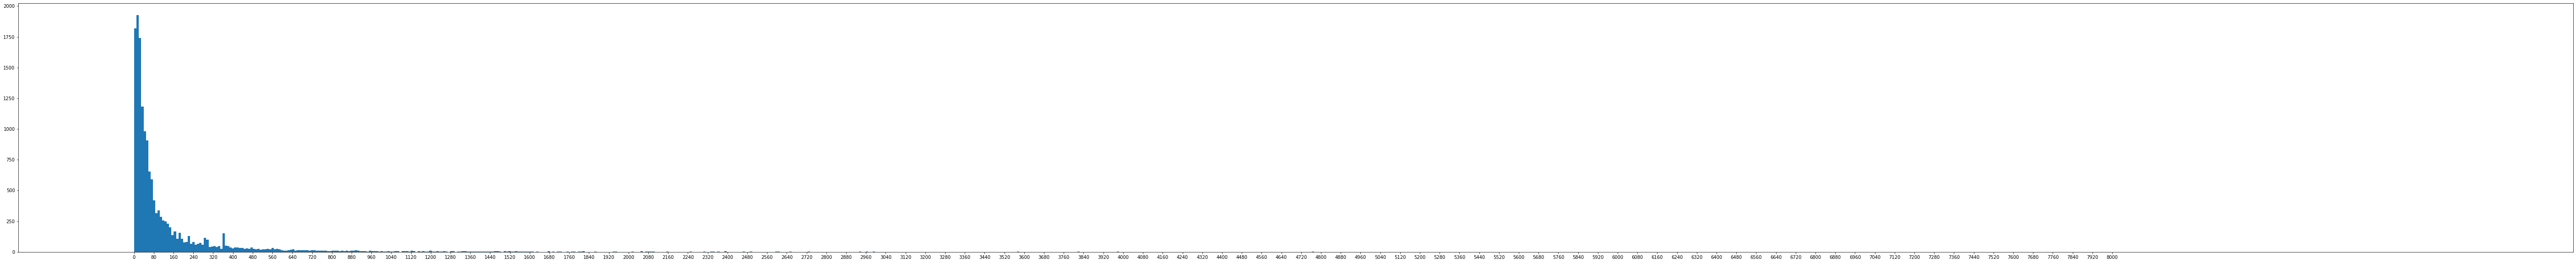

In [325]:
plt.rcParams['figure.figsize']=(100,10)
plt.hist([item[1] for item in my_coword_g.degree()], bins=1000)
plt.xticks(np.linspace(0,8000,101))
plt.show()

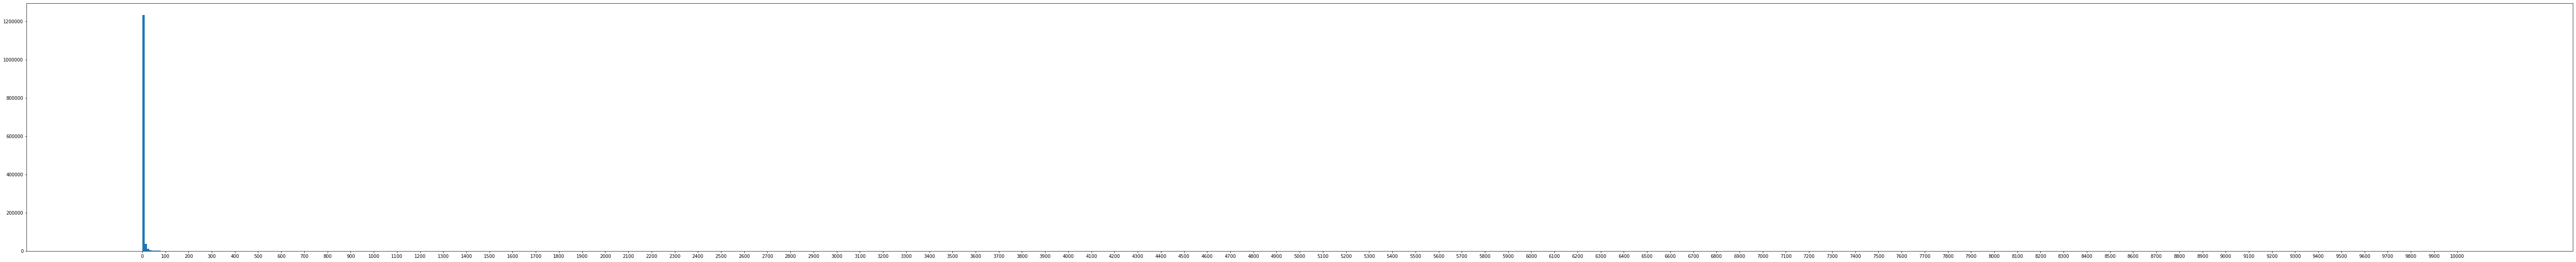

In [326]:
plt.rcParams['figure.figsize']=(100,10)
plt.hist([item[2]['weight'] for item in my_coword_g.edges(data = True)], bins=1000,range=(0,10000))
plt.xticks(np.linspace(0,10000,101))
plt.show()

Surprisingly, there are no isolated words in the insulting comment collections, which reveals the fact that those insulting comments are unlikely to occure in the format of a single word. Also, from the histogram we can see that the connectivity degrees of words generally obey the power law: most words have only a small number of neighbors, while few words have high connectivity degrees.  

In [327]:
my_coword_g.remove_edges_from([(n1, n2) for n1, n2, d in my_coword_g.edges(data = True) if d['weight'] <= 3 or n1 == n2])
my_coword_g.remove_nodes_from(list(nx.isolates(my_coword_g)))

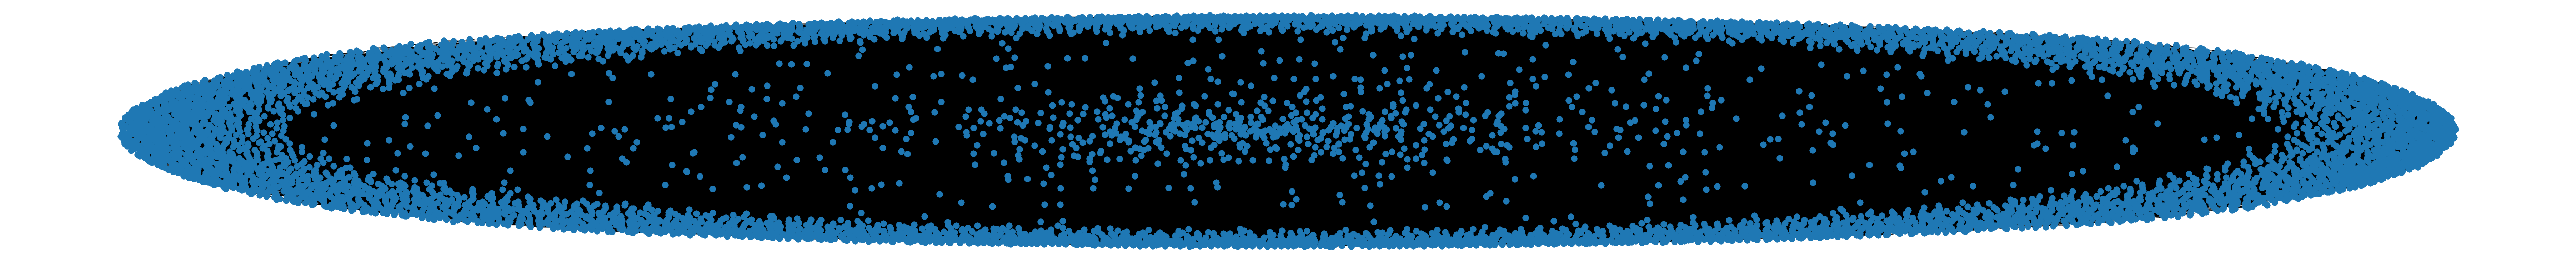

In [328]:
nx.draw(my_coword_g, pos=nx.spring_layout(my_coword_g, k = 2), width = 0.5)

The network graph basically verifies what we have found above, most words just distributed on the periphery of the network, having only samll number of neighbors nearby, and a few words that locate at the center of the network have a much broader range of words to co-occure.

In [329]:
insult_senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
noninsult_senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
insult_senVects_incidence = insult_senVectorizer.fit_transform(my_insult['comment_text'][:1000])
noninsult_senVects_incidence = noninsult_senVectorizer.fit_transform(my_noninsult['comment_text'][:1000])

In [330]:
# construct the graph for the insult subset
my_insult_2mode = nx.Graph()

#define all the nodes
my_insult_2mode.add_nodes_from((insult_senVectorizer.get_feature_names()[i] for i in range(insult_senVects_incidence.shape[1])), 
                               bipartite = 'word')
my_insult_2mode.add_nodes_from(range(len(my_insult[:1000])), bipartite = 'comment')

#add all the edges
my_insult_2mode.add_edges_from(((d, insult_senVectorizer.get_feature_names()[w], 
                                 {'weight' : insult_senVects_incidence[d, w]}) for d, w in zip(*insult_senVects_incidence.nonzero())))

In [331]:
print(nx.info(my_insult_2mode))

Name: 
Type: Graph
Number of nodes: 5662
Number of edges: 15740
Average degree:   5.5599


In [332]:
insult_gCom = contractNetwork(my_insult_2mode, 'comment')
print(nx.info(insult_gCom))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 202956
Average degree: 405.9120


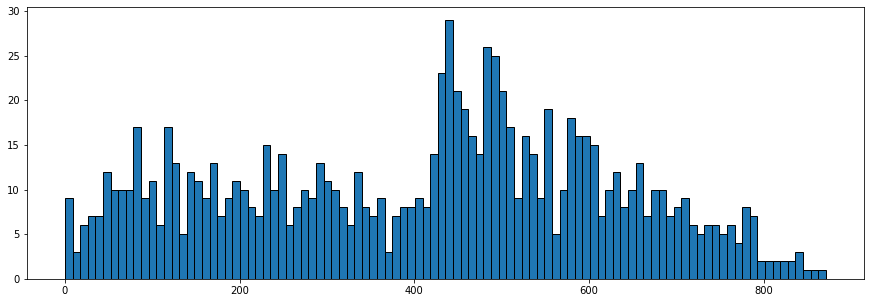

In [333]:
plt.rcParams['figure.figsize']=(15,5)
plt.hist([item[1] for item in insult_gCom.degree()], bins=100, edgecolor='k')
plt.show()

In [334]:
insult_gWord = contractNetwork(my_insult_2mode, 'word')
print(nx.info(insult_gWord))

Name: 
Type: Graph
Number of nodes: 4662
Number of edges: 279082
Average degree: 119.7263


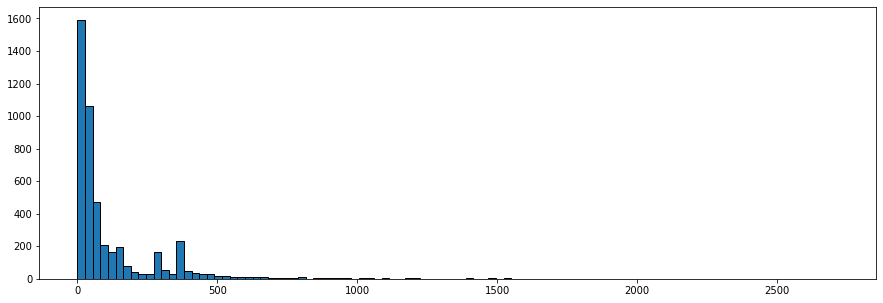

In [335]:
plt.rcParams['figure.figsize']=(15,5)
plt.hist([item[1] for item in insult_gWord.degree()], bins=100, edgecolor='k')
plt.show()

Interestingly, we found in the insulting subset that the degrees of word-document do not conform to the power law while the degrees of word-word in the document still follow this rule. We would like to plot a subgraph of filtered frequently used words in insulting comment collection. 

In [336]:
insult_top_degrees = sorted(insult_gWord.degree(),key = lambda x:x[1],reverse = True)[:20]
insult_top_degrees

[('fuck', 2719),
 ('s', 2559),
 ('t', 2433),
 ('like', 1970),
 ('don', 1734),
 ('wikipedia', 1695),
 ('shit', 1581),
 ('think', 1552),
 ('be', 1540),
 ('have', 1536),
 ('ass', 1531),
 ('people', 1483),
 ('ing', 1481),
 ('life', 1476),
 ('way', 1430),
 ('edit', 1414),
 ('go', 1410),
 ('page', 1410),
 ('know', 1356),
 ('good', 1314)]

In [337]:
insult_top_neighbors = set()
for i in insult_top_degrees:
    insult_top_neighbors.add(i[0])
    insult_top_neighbors |= set(insult_gWord[i[0]])

insult_top_g = insult_gWord.subgraph(insult_top_neighbors)
insult_top_g = nx.Graph(insult_top_g)
insult_top_words = [x[0] for x in insult_top_degrees]
insult_top_g.remove_edges_from(
    [(n1, n2) for n1, n2 in insult_top_g.edges() if (n1 not in insult_top_words) and (n2 not in insult_top_words)])
print(nx.info(insult_top_g))

Name: 
Type: Graph
Number of nodes: 4400
Number of edges: 33434
Average degree:  15.1973


Using the top 20 words, we can found out that we can already connect most of the words in the collection, which indicates that those words have greater impact on producing insulting meanings.

In [338]:
# construct the graph for the non-insult subset
my_noninsult_2mode = nx.Graph()

#define all the nodes
my_noninsult_2mode.add_nodes_from((noninsult_senVectorizer.get_feature_names()[i] for i in range(noninsult_senVects_incidence.shape[1])), 
                                   bipartite = 'word')
my_noninsult_2mode.add_nodes_from(range(len(my_noninsult[:1000])), bipartite = 'comment')

#add all the edges
my_noninsult_2mode.add_edges_from(((d, noninsult_senVectorizer.get_feature_names()[w], 
                                 {'weight' : noninsult_senVects_incidence[d, w]}) for d, w in zip(*noninsult_senVects_incidence.nonzero())))

In [339]:
print(nx.info(my_noninsult_2mode))

Name: 
Type: Graph
Number of nodes: 8052
Number of edges: 25805
Average degree:   6.4096


In [340]:
noninsult_gCom = contractNetwork(my_noninsult_2mode, 'comment')
print(nx.info(noninsult_gCom))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 210068
Average degree: 420.1360


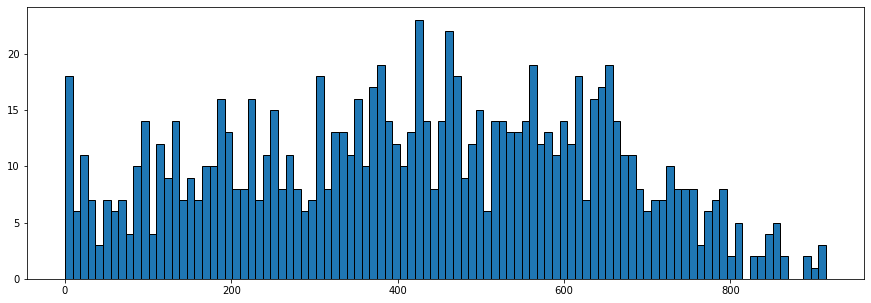

In [341]:
plt.rcParams['figure.figsize']=(15,5)
plt.hist([item[1] for item in noninsult_gCom.degree()], bins=100, edgecolor='k')
plt.show()

In [342]:
noninsult_gWord = contractNetwork(my_noninsult_2mode, 'word')
print(nx.info(noninsult_gWord))

Name: 
Type: Graph
Number of nodes: 7052
Number of edges: 604695
Average degree: 171.4960


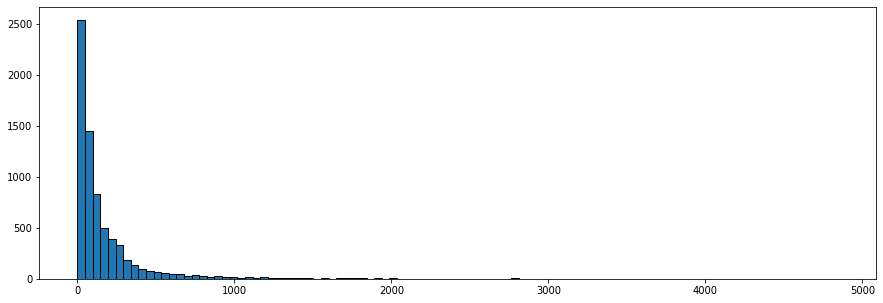

In [343]:
plt.rcParams['figure.figsize']=(15,5)
plt.hist([item[1] for item in noninsult_gWord.degree()], bins=100, edgecolor='k')
plt.show()

In [344]:
noninsult_top_degrees = sorted(noninsult_gWord.degree(),key = lambda x:x[1],reverse = True)[:20]
noninsult_top_degrees

[('s', 4848),
 ('t', 3982),
 ('article', 3580),
 ('have', 3135),
 ('wikipedia', 3039),
 ('like', 2908),
 ('know', 2809),
 ('think', 2801),
 ('page', 2791),
 ('time', 2595),
 ('say', 2560),
 ('don', 2559),
 ('talk', 2518),
 ('be', 2447),
 ('edit', 2436),
 ('people', 2382),
 ('look', 2259),
 ('source', 2259),
 ('want', 2218),
 ('write', 2184)]

In [345]:
noninsult_top_neighbors = set()
for i in noninsult_top_degrees:
    noninsult_top_neighbors.add(i[0])
    noninsult_top_neighbors |= set(noninsult_gWord[i[0]])

noninsult_top_g = noninsult_gWord.subgraph(noninsult_top_neighbors)
noninsult_top_g = nx.Graph(noninsult_top_g)
noninsult_top_words = [x[0] for x in noninsult_top_degrees]
noninsult_top_g.remove_edges_from(
    [(n1, n2) for n1, n2 in noninsult_top_g.edges() if (n1 not in noninsult_top_words) and (n2 not in noninsult_top_words)])
print(nx.info(noninsult_top_g))

Name: 
Type: Graph
Number of nodes: 6732
Number of edges: 56120
Average degree:  16.6726


Basically, we see that words in the noninsulting dataset also conform to the similar distributions as those in the insulting dataset. One difference is that the number of nodes in the word network becomes larger in the noninsulting set. This is consistent with what has been discovered in previous homework that the words in insulting comments are more repetitive.

In [346]:
share_words = set(noninsult_senVectorizer.get_feature_names()) & set(insult_senVectorizer.get_feature_names())
len(share_words)

2201

In [347]:
insult_sharewords_g = insult_gWord.subgraph(share_words)
noninsult_sharewords_g = noninsult_gWord.subgraph(share_words)

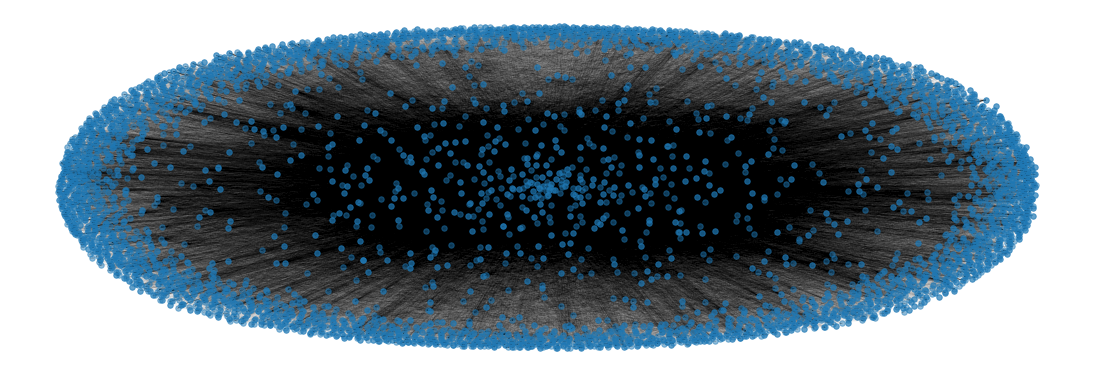

In [348]:
insult_wMedian = np.median([d['weight'] for n1, n2, d in insult_sharewords_g.edges(data = True)])
insult_edgesHigh = [(n1, n2) for n1, n2, d in insult_sharewords_g.edges(data = True) if d['weight'] > insult_wMedian]
insult_edgesLow = [(n1, n2) for n1, n2, d in insult_sharewords_g.edges(data = True) if d['weight'] <= insult_wMedian]
nx.draw(insult_sharewords_g, pos = nx.spring_layout(insult_sharewords_g, k = 2), edgelist = insult_edgesLow, width = 0.005, alpha = 0.5,
        labels = {n:n for n in insult_sharewords_g.nodes()}, node_size = 30, font_size = 1)
nx.draw(insult_sharewords_g, pos = nx.spring_layout(insult_sharewords_g, k = 2), edgelist = insult_edgesHigh, width = 0.05, alpha = 0.7,
        node_size = 30)

In [349]:
sorted(insult_sharewords_g.degree(),key = lambda x:x[1],reverse = True)[:20]

[('s', 1507),
 ('fuck', 1483),
 ('t', 1432),
 ('like', 1213),
 ('wikipedia', 1118),
 ('don', 1093),
 ('have', 1000),
 ('shit', 995),
 ('think', 985),
 ('people', 983),
 ('ass', 966),
 ('be', 936),
 ('ing', 935),
 ('page', 925),
 ('life', 912),
 ('edit', 904),
 ('way', 869),
 ('go', 867),
 ('know', 852),
 ('time', 830)]

In [350]:
len(insult_edgesHigh)/len(insult_sharewords_g.edges())

0.14627261419750787

In [351]:
insult_ave_degree = np.mean([d[1] for d in insult_sharewords_g.degree()])
len([n for n in insult_sharewords_g.nodes() if insult_sharewords_g.degree[n] >= insult_ave_degree])/len(insult_sharewords_g.nodes())

0.3203089504770559

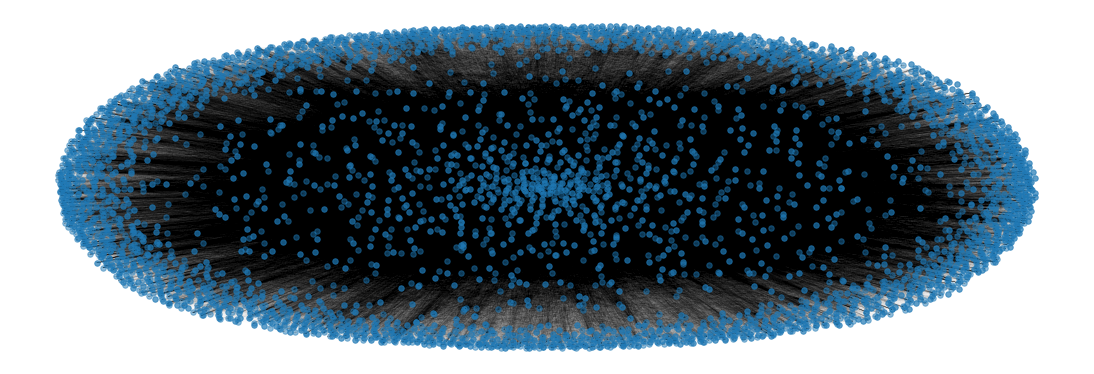

In [352]:
noninsult_wMedian = np.median([d['weight'] for n1, n2, d in noninsult_sharewords_g.edges(data = True)])
noninsult_edgesHigh = [(n1, n2) for n1, n2, d in noninsult_sharewords_g.edges(data = True) if d['weight'] > noninsult_wMedian]
noninsult_edgesLow = [(n1, n2) for n1, n2, d in noninsult_sharewords_g.edges(data = True) if d['weight'] <= noninsult_wMedian]
nx.draw(noninsult_sharewords_g, pos = nx.spring_layout(noninsult_sharewords_g, k = 2), edgelist = noninsult_edgesLow, width = 0.005, 
        labels = {n:n for n in noninsult_sharewords_g.nodes()}, alpha =0.5,node_size = 30, font_size = 1)
nx.draw(noninsult_sharewords_g, pos = nx.spring_layout(noninsult_sharewords_g, k = 2), edgelist = noninsult_edgesHigh, width = 0.05,
       alpha = 0.7,node_size = 30)

In [353]:
sorted(noninsult_sharewords_g.degree(),key = lambda x:x[1],reverse = True)[:20]

[('s', 1848),
 ('t', 1675),
 ('article', 1538),
 ('have', 1437),
 ('wikipedia', 1409),
 ('like', 1371),
 ('think', 1329),
 ('know', 1324),
 ('page', 1313),
 ('don', 1279),
 ('say', 1265),
 ('time', 1243),
 ('talk', 1243),
 ('be', 1217),
 ('edit', 1192),
 ('people', 1180),
 ('want', 1139),
 ('look', 1134),
 ('way', 1107),
 ('try', 1102)]

In [354]:
len(noninsult_edgesHigh)/len(noninsult_sharewords_g.edges())

0.25663887754788467

In [355]:
noninsult_ave_degree = np.mean([d[1] for d in noninsult_sharewords_g.degree()])
len([n for n in noninsult_sharewords_g.nodes() if noninsult_sharewords_g.degree[n] >= noninsult_ave_degree])/len(noninsult_sharewords_g.nodes())

0.3407542026351658

In [356]:
from networkx.algorithms.community import greedy_modularity_communities
insult_community = list(greedy_modularity_communities(insult_sharewords_g))
noninsult_community = list(greedy_modularity_communities(noninsult_sharewords_g))

In [357]:
len(insult_community)

5

In [358]:
for i in insult_community:
    print(len(i))

1943
157
99
1
1


In [359]:
for i in noninsult_community:
    print(len(i))

2201


From above network plots, we could see that for the same group of words, a smaller percentage of them in the insulting set tend to have higher edge weights while a larger percentage of them in the noninsulting set seems to have more connections to other words. Also, when we examine those words that have the largest degrees in the network, the insulting set contains dirty words like "fuck" and “shit” while the noninsulting  set does not. Some words like "like:, "wikipedia" and "people" occurs very frequently in both sets, so we might need to decrease their impact (using tf-idf) if we need to further explore the differences between the two sets.

When we see the community distributions, the two sets show difference again where the words in the noninsult set belong to 1 community and they are separated to 5 communities when used in the insulting set.

# Network Statistics
We can often gain more insight into our semantic network through statistics that describe the positions of words within it.

We begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. The most straightforward is the notion of degree centrality: those nodes that have the highest number of connections are the most central. Here our measure normalizes the number of connections by those with the most connections.

In [ ]:
dcentralities = nx.degree_centrality(giant)

In [ ]:
dcentralities['american']

In [ ]:
max(dcentralities.items(), key = lambda x : x[1])

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout.

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight:

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of degree centrality is:

In [ ]:
plt.hist(list(dcentralities.values()))
plt.show()

What are the top and bottom ten words in terms of degree?

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

Consider another very different measure, which is *betweenness* centrality. Betweenness centrality distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. In other words, high *betweenness centrality* nodes may not have the highest *degree centrality*.

In [ ]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [ ]:
centralities['american']

In [ ]:
max(centralities.items(), key = lambda x : x[1])

We can color and size the nodes by betweenness centrality:

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of betweenness centrality is:

In [ ]:
plt.hist(list(centralities.values()))
plt.show()

This is an exponential distrubution, but you might need to add more nodes to see it clearly.

What are the top ten words in terms of betweenness?

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

What are words lower down?

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [ ]:
centralities = nx.closeness_centrality(giant)

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Top and bottom:

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [ ]:
centralities = nx.eigenvector_centrality(giant)

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Note how the colors reveal a much more graduate distribution here. Let's look at it directly.

In [ ]:
plt.hist(list(centralities.values()))
plt.show()

Top and bottom:

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

We can now filter our network by a centrality measure. Let's define a function and experiment with it:

In [360]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [ ]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

In [ ]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

We can also look at global statistics, like the density of a network, defined as the number of actual edges divided by the total number of possible edges:

In [ ]:
nx.density(giant)

We can also calculate the average degree per node:

In [ ]:
np.mean([v for w,v in nx.degree(giant)])

The diameter calculates the average distance between any two nodes in the network:

In [ ]:
nx.diameter(giant)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

In [361]:
# We would also like to compare the words occured both in insulting and non-insulting dataset
insult_word_g = nx.Graph(insult_sharewords_g)
noninsult_word_g = nx.Graph(noninsult_sharewords_g)

In [362]:
# compute the degree, between and closeness centrality of the network
insult_degree_centrality = nx.degree_centrality(insult_word_g)
noninsult_degree_centrality = nx.degree_centrality(noninsult_word_g)

insult_betweenness_centrality = nx.betweenness_centrality(insult_word_g)
noninsult_betweenness_centrality = nx.betweenness_centrality(noninsult_word_g)

insult_closeness_centrality = nx.closeness_centrality(insult_word_g)
noninsult_closeness_centrality = nx.closeness_centrality(noninsult_word_g)

Text(0.5, 1.0, 'noninsult closeness centrality')

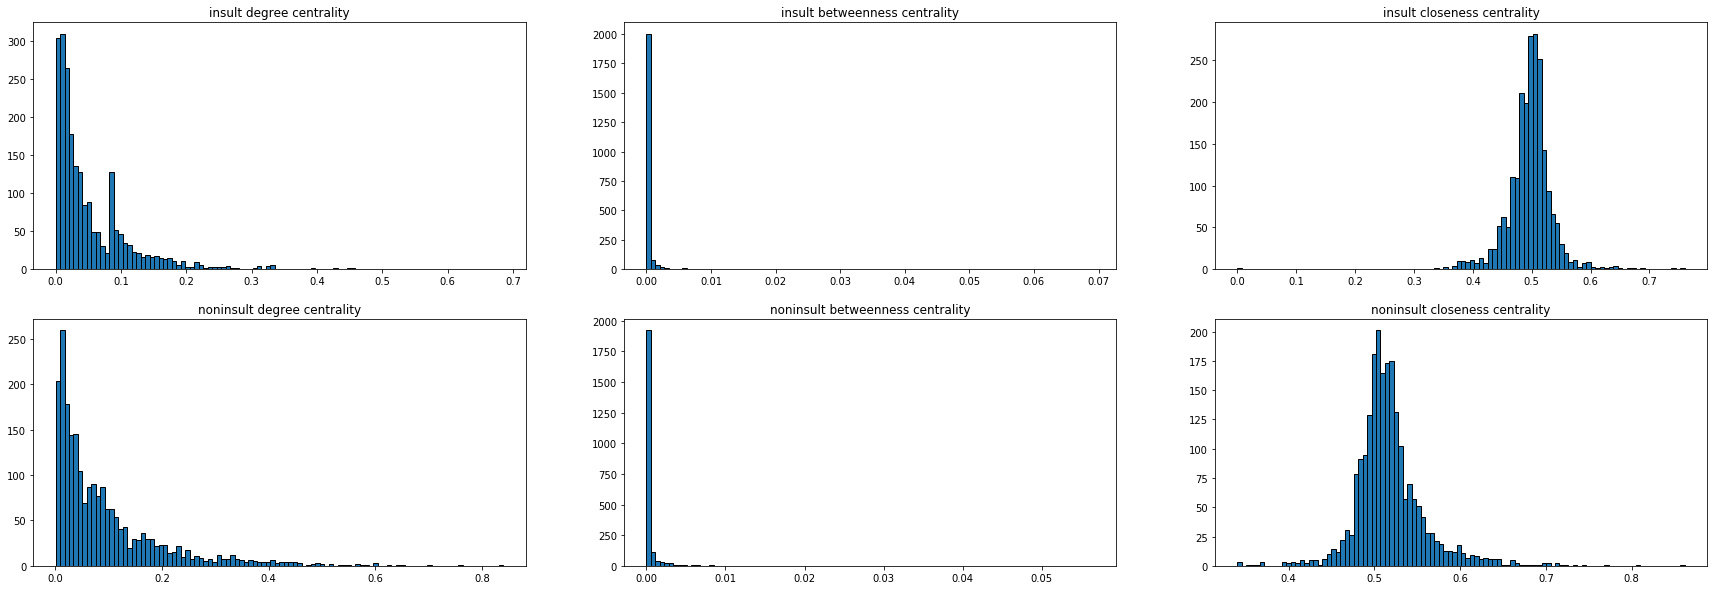

In [363]:
# plot the histogram of three different centralities
plt.rcParams['figure.figsize'] = (30,10)
fig, axes = plt.subplots(2,3)
axes[0,0].hist(insult_degree_centrality.values(), bins=100, edgecolor='k')
axes[0,0].set_title('insult degree centrality')
axes[1,0].hist(noninsult_degree_centrality.values(), bins=100, edgecolor='k')
axes[1,0].set_title('noninsult degree centrality')
axes[0,1].hist(insult_betweenness_centrality.values(), bins=100, edgecolor='k')
axes[0,1].set_title('insult betweenness centrality')
axes[1,1].hist(noninsult_betweenness_centrality.values(), bins=100, edgecolor='k')
axes[1,1].set_title('noninsult betweenness centrality')
axes[0,2].hist(insult_closeness_centrality.values(), bins=100, edgecolor='k')
axes[0,2].set_title('insult closeness centrality')
axes[1,2].hist(noninsult_closeness_centrality.values(), bins=100, edgecolor='k')
axes[1,2].set_title('noninsult closeness centrality')

From above histograms, we can see that the degree centrality and betweenness centrality in both sets also obey the power law. However, the closeness centrality is more like a normal distribution. Also, the actual distribution of them are quite similar in these two datasets, which might indicate that the overall distributions of different centrality might not be a good index to distinguish insulting and non-insulting comments.   

In [364]:
top_insult_degree = sorted(insult_degree_centrality.items(), key=lambda x:x[1], reverse=True)[:20]
top_noninsult_degree = sorted(noninsult_degree_centrality.items(), key=lambda x:x[1], reverse=True)[:20]
top_insult_betweenness = sorted(insult_betweenness_centrality.items(), key=lambda x:x[1], reverse=True)[:20]
top_noninsult_betweenness = sorted(noninsult_betweenness_centrality.items(), key=lambda x:x[1], reverse=True)[:20]
top_insult_closeness = sorted(insult_closeness_centrality.items(), key=lambda x:x[1], reverse=True)[:20]
top_noninsult_closeness = sorted(noninsult_closeness_centrality.items(), key=lambda x:x[1], reverse=True)[:20]

In [365]:
insult_words = set([x[0] for x in top_insult_degree]) | set([x[0] for x in top_insult_betweenness]) | \
               set([x[0] for x in top_insult_closeness])
noninsult_words = set([x[0] for x in top_noninsult_degree]) | set([x[0] for x in top_noninsult_betweenness]) | \
               set([x[0] for x in top_noninsult_closeness])

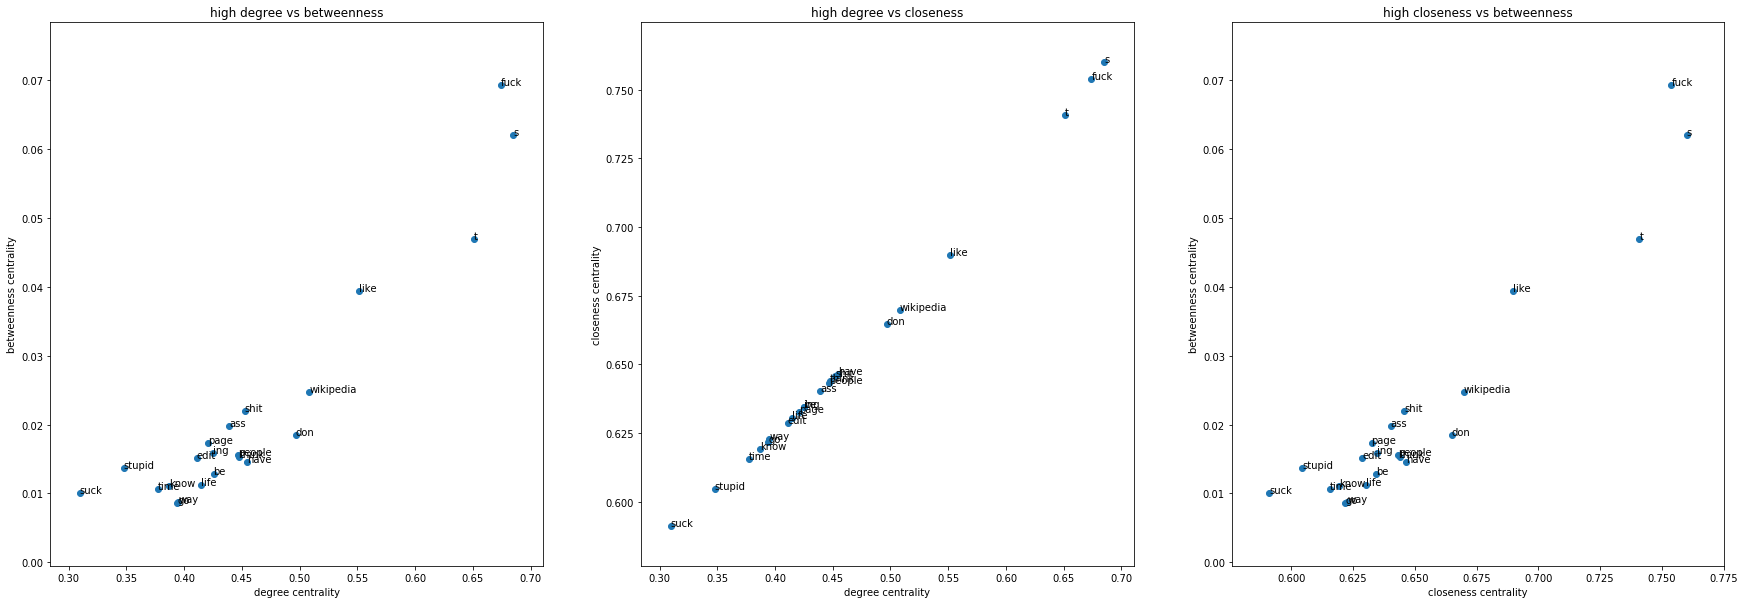

In [366]:
# insulting high centrality word plots
fig, axes = plt.subplots(1,3)
axes[0].scatter([insult_degree_centrality[w] for w in insult_words],
                [insult_betweenness_centrality[w] for w in insult_words])
axes[0].set_title('high degree vs betweenness')
axes[0].set_xlabel('degree centrality')
axes[0].set_ylabel('betweenness centrality')

axes[1].scatter([insult_degree_centrality[w] for w in insult_words],
                [insult_closeness_centrality[w] for w in insult_words])
axes[1].set_title('high degree vs closeness')
axes[1].set_xlabel('degree centrality')
axes[1].set_ylabel('closeness centrality')

axes[2].scatter([insult_closeness_centrality[w] for w in insult_words],
                [insult_betweenness_centrality[w] for w in insult_words])
axes[2].set_title('high closeness vs betweenness')
axes[2].set_xlabel('closeness centrality')
axes[2].set_ylabel('betweenness centrality')

for w in insult_words:
    axes[0].annotate(w, (insult_degree_centrality[w],insult_betweenness_centrality[w]))
    axes[1].annotate(w, (insult_degree_centrality[w],insult_closeness_centrality[w]))
    axes[2].annotate(w, (insult_closeness_centrality[w],insult_betweenness_centrality[w]))
plt.show()

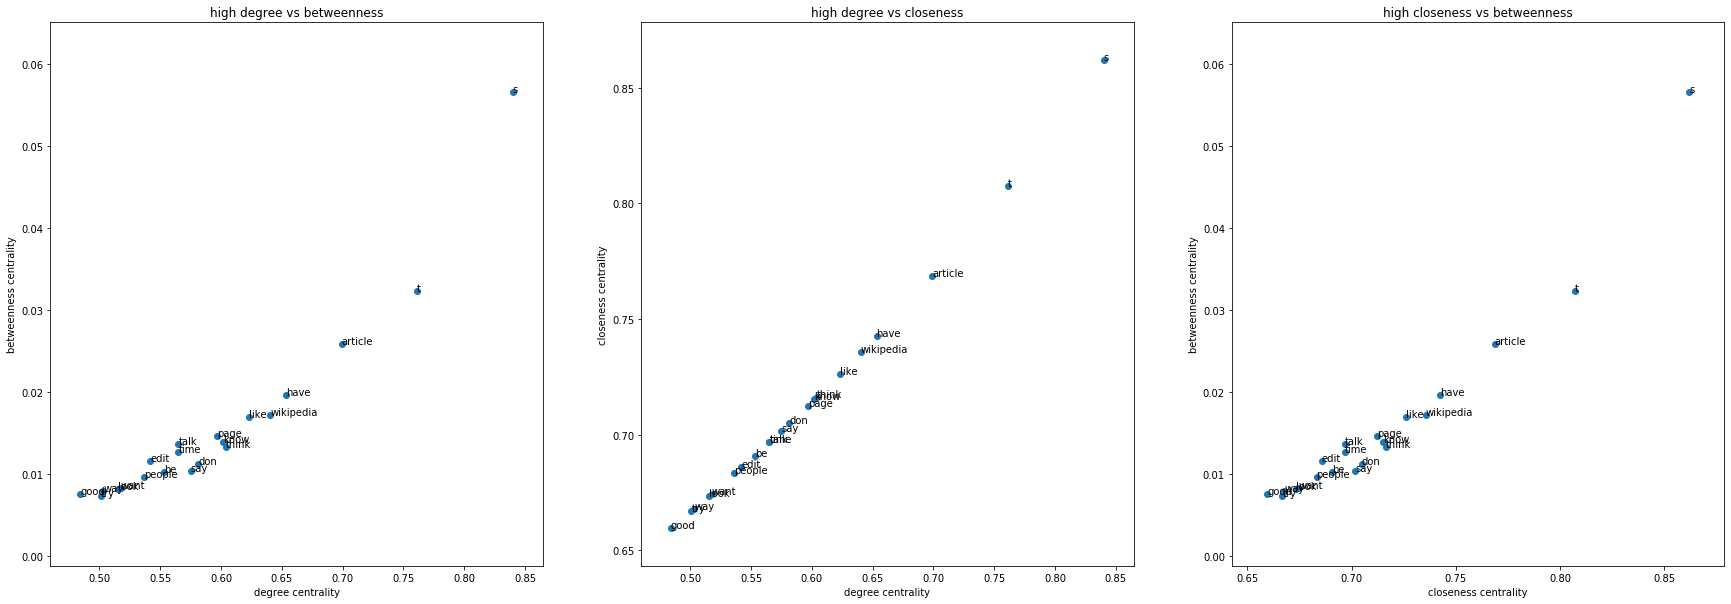

In [367]:
# noninsulting high centrality word plots
fig, axes = plt.subplots(1,3)
axes[0].scatter([noninsult_degree_centrality[w] for w in noninsult_words],
                [noninsult_betweenness_centrality[w] for w in noninsult_words])
axes[0].set_title('high degree vs betweenness')
axes[0].set_xlabel('degree centrality')
axes[0].set_ylabel('betweenness centrality')

axes[1].scatter([noninsult_degree_centrality[w] for w in noninsult_words],
                [noninsult_closeness_centrality[w] for w in noninsult_words])
axes[1].set_title('high degree vs closeness')
axes[1].set_xlabel('degree centrality')
axes[1].set_ylabel('closeness centrality')

axes[2].scatter([noninsult_closeness_centrality[w] for w in noninsult_words],
                [noninsult_betweenness_centrality[w] for w in noninsult_words])
axes[2].set_title('high closeness vs betweenness')
axes[2].set_xlabel('closeness centrality')
axes[2].set_ylabel('betweenness centrality')

for w in noninsult_words:
    axes[0].annotate(w, (noninsult_degree_centrality[w], noninsult_betweenness_centrality[w]))
    axes[1].annotate(w, (noninsult_degree_centrality[w], noninsult_closeness_centrality[w]))
    axes[2].annotate(w, (noninsult_closeness_centrality[w], noninsult_betweenness_centrality[w]))
plt.show()

From these graphes, we see that for both the insulting and non-insulting words of top centrality, the three kinds of centrality reveals great positive correlations, which means that if one word has a high centrality in one kind, it is likely to have high centrality in other kinds. But if we step to see the exact words in these two datasets, there are still some significant difference. All insulting words ranked at a high position do not show up in the non-insulting word centrality plots. So I think if we need to make identifications between these 2 types of comments, the meaning of words is a key point.    

In [368]:
bottom_insult_degree = sorted(insult_degree_centrality.items(), key=lambda x:x[1], reverse=True)[-20:]
bottom_noninsult_degree = sorted(noninsult_degree_centrality.items(), key=lambda x:x[1], reverse=True)[-20:]
bottom_insult_betweenness = sorted(insult_betweenness_centrality.items(), key=lambda x:x[1], reverse=True)[-20:]
bottom_noninsult_betweenness = sorted(noninsult_betweenness_centrality.items(), key=lambda x:x[1], reverse=True)[-20:]
bottom_insult_closeness = sorted(insult_closeness_centrality.items(), key=lambda x:x[1], reverse=True)[-20:]
bottom_noninsult_closeness = sorted(noninsult_closeness_centrality.items(), key=lambda x:x[1], reverse=True)[-20:]

In [369]:
insult_words = set([x[0] for x in bottom_insult_degree]) | set([x[0] for x in bottom_insult_betweenness]) | \
               set([x[0] for x in bottom_insult_closeness])
noninsult_words = set([x[0] for x in bottom_noninsult_degree]) | set([x[0] for x in bottom_noninsult_betweenness]) | \
               set([x[0] for x in bottom_noninsult_closeness])

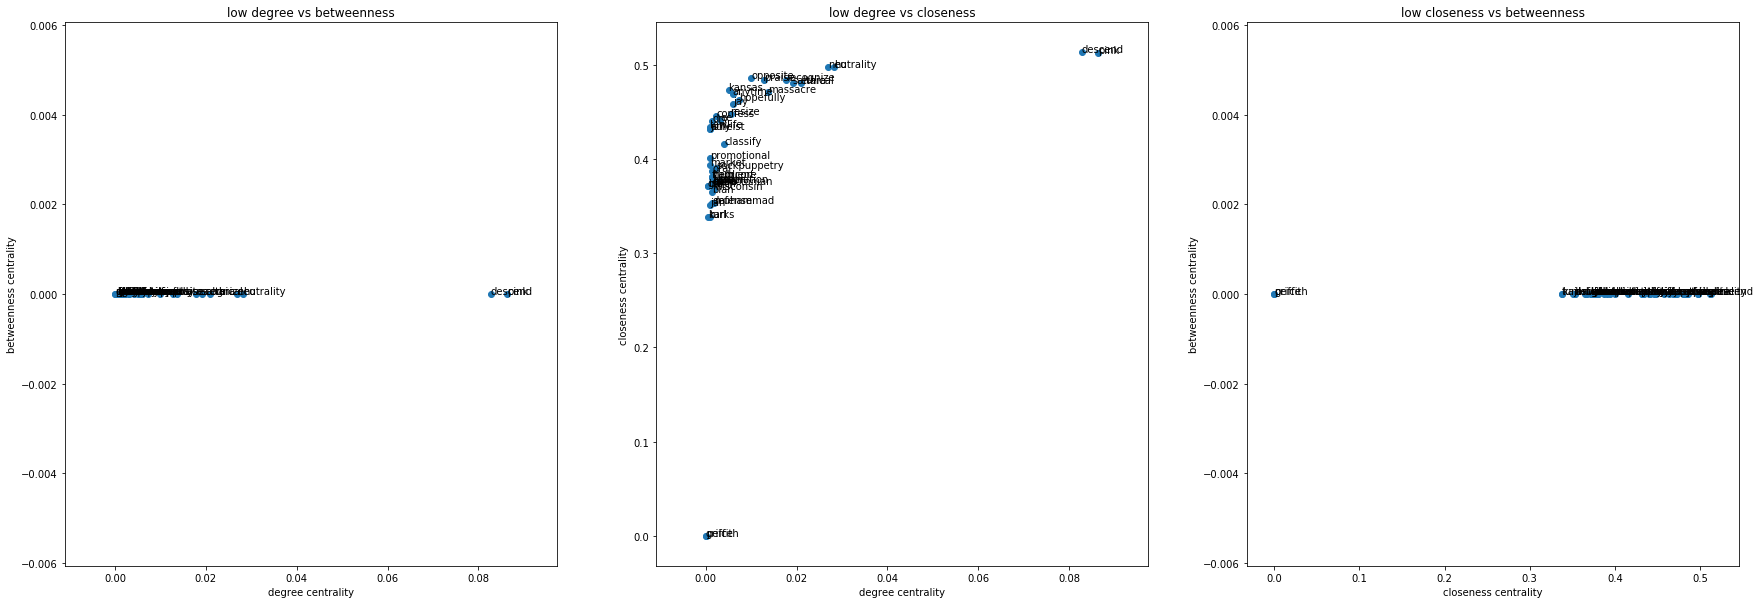

In [370]:
# insulting low centrality word plots
fig, axes = plt.subplots(1,3)
axes[0].scatter([insult_degree_centrality[w] for w in insult_words],
                [insult_betweenness_centrality[w] for w in insult_words])
axes[0].set_title('low degree vs betweenness')
axes[0].set_xlabel('degree centrality')
axes[0].set_ylabel('betweenness centrality')

axes[1].scatter([insult_degree_centrality[w] for w in insult_words],
                [insult_closeness_centrality[w] for w in insult_words])
axes[1].set_title('low degree vs closeness')
axes[1].set_xlabel('degree centrality')
axes[1].set_ylabel('closeness centrality')

axes[2].scatter([insult_closeness_centrality[w] for w in insult_words],
                [insult_betweenness_centrality[w] for w in insult_words])
axes[2].set_title('low closeness vs betweenness')
axes[2].set_xlabel('closeness centrality')
axes[2].set_ylabel('betweenness centrality')

for w in insult_words:
    axes[0].annotate(w, (insult_degree_centrality[w],insult_betweenness_centrality[w]))
    axes[1].annotate(w, (insult_degree_centrality[w],insult_closeness_centrality[w]))
    axes[2].annotate(w, (insult_closeness_centrality[w],insult_betweenness_centrality[w]))
plt.show()

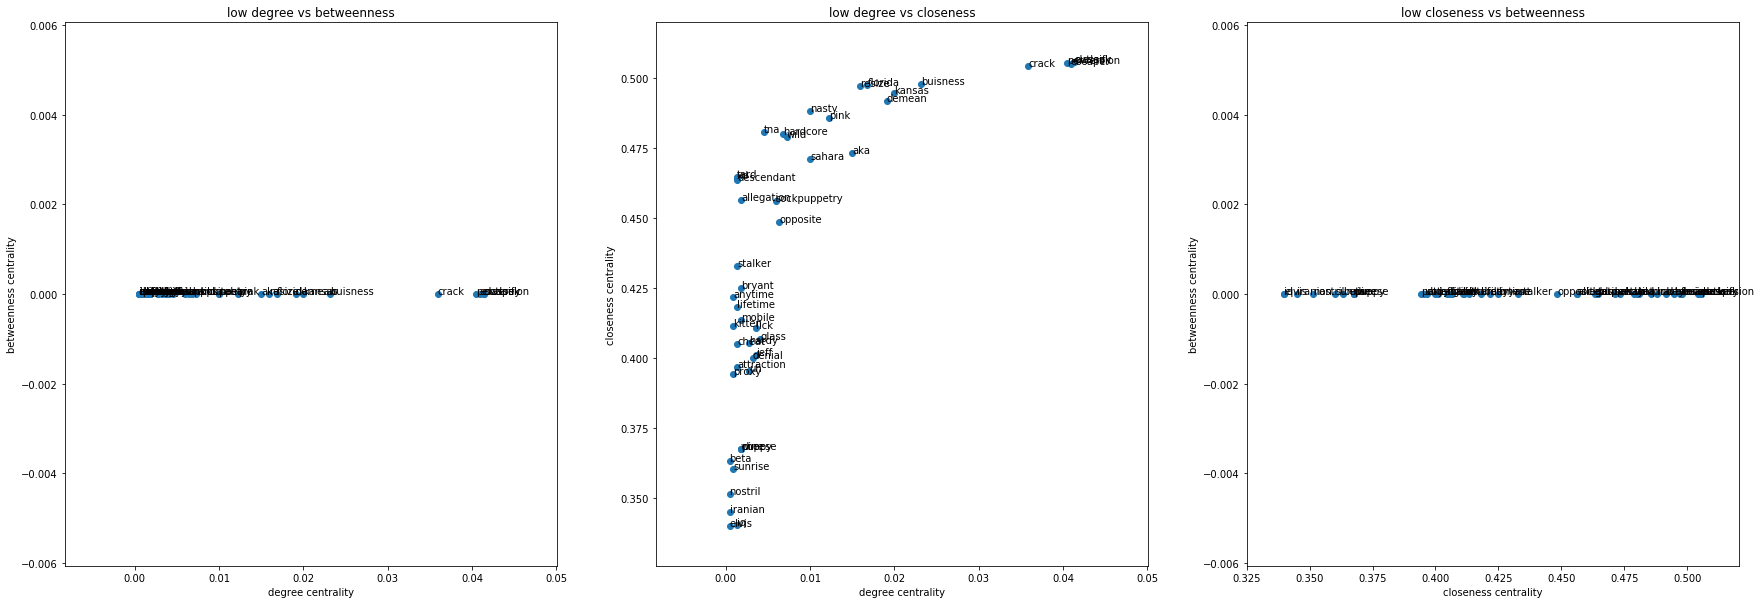

In [371]:
# noninsulting high centrality word plots
fig, axes = plt.subplots(1,3)
axes[0].scatter([noninsult_degree_centrality[w] for w in noninsult_words],
                [noninsult_betweenness_centrality[w] for w in noninsult_words])
axes[0].set_title('low degree vs betweenness')
axes[0].set_xlabel('degree centrality')
axes[0].set_ylabel('betweenness centrality')

axes[1].scatter([noninsult_degree_centrality[w] for w in noninsult_words],
                [noninsult_closeness_centrality[w] for w in noninsult_words])
axes[1].set_title('low degree vs closeness')
axes[1].set_xlabel('degree centrality')
axes[1].set_ylabel('closeness centrality')

axes[2].scatter([noninsult_closeness_centrality[w] for w in noninsult_words],
                [noninsult_betweenness_centrality[w] for w in noninsult_words])
axes[2].set_title('low closeness vs betweenness')
axes[2].set_xlabel('closeness centrality')
axes[2].set_ylabel('betweenness centrality')

for w in noninsult_words:
    axes[0].annotate(w, (noninsult_degree_centrality[w], noninsult_betweenness_centrality[w]))
    axes[1].annotate(w, (noninsult_degree_centrality[w], noninsult_closeness_centrality[w]))
    axes[2].annotate(w, (noninsult_closeness_centrality[w], noninsult_betweenness_centrality[w]))
plt.show()

When we look at the low centrality words in both sets, they also share similar distributions, but quite different from that of those top centrality words. These words typically have very low betweenness centrality (close to 0) and low degree centralities. Unlike what we might speculate, the bottom words in the insulting set is not something generally thought as positive like "good" or "excellent", but instead are those words that might be thought of as too formal in online environment, like "mentor", "expression". 

In [372]:
insult_degree_filtered = filterWords(insult_word_g, minWeight=10, filter_='degree', rule='number', value_of_rule=100)
print(nx.info(insult_degree_filtered))

Total number of nodes(after filtering) in the graph is 100
Name: 
Type: Graph
Number of nodes: 100
Number of edges: 636
Average degree:  12.7200


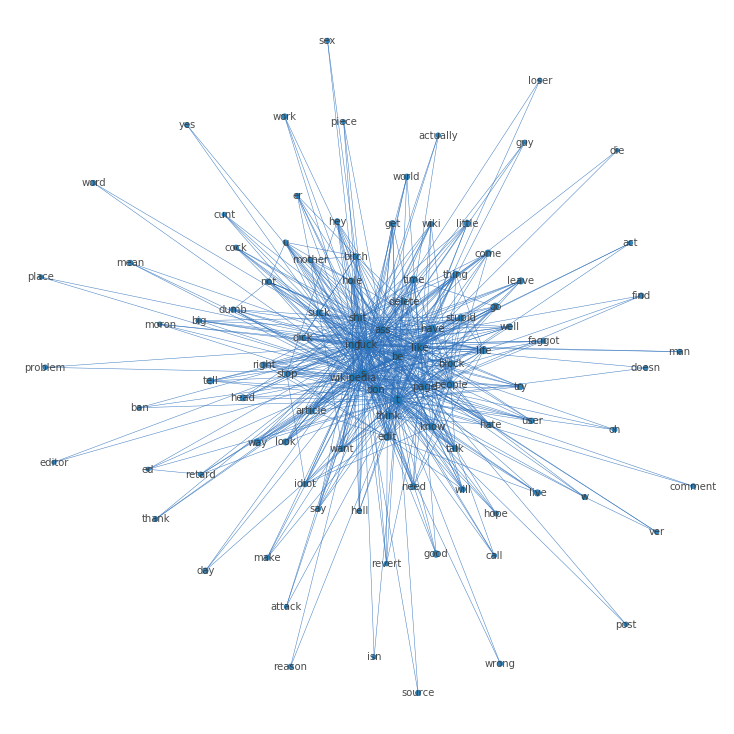

In [373]:
plt.rcParams['figure.figsize'] = (10,10)
insult_maxC = max(nx.degree_centrality(insult_degree_filtered).items(), key = lambda x : x[1])[1]
nx.draw(insult_degree_filtered, 
        pos = nx.spring_layout(insult_degree_filtered, weight='weight', iterations= 100), 
        labels = {n: n for n in insult_degree_filtered.nodes()},
        alpha = .9, 
        width = .5,
        node_size = [insult_degree_centrality[n] / insult_maxC * 100 for n in insult_degree_filtered.nodes],
        font_size = 10,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [374]:
noninsult_degree_filtered = filterWords(noninsult_word_g, minWeight=10, filter_='degree', rule='number', value_of_rule=100)
print(nx.info(noninsult_degree_filtered))

Total number of nodes(after filtering) in the graph is 100
Name: 
Type: Graph
Number of nodes: 100
Number of edges: 1642
Average degree:  32.8400


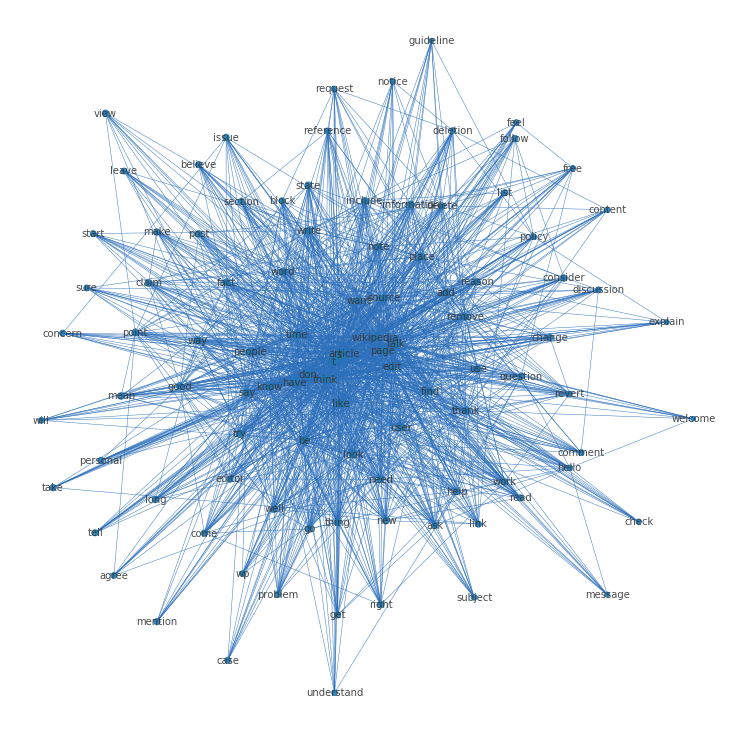

In [375]:
plt.rcParams['figure.figsize'] = (10,10)
noninsult_maxC = max(nx.degree_centrality(noninsult_degree_filtered).items(), key = lambda x : x[1])[1]
nx.draw(noninsult_degree_filtered, 
        pos = nx.spring_layout(noninsult_degree_filtered, weight='weight', iterations= 100), 
        labels = {n: n for n in noninsult_degree_filtered.nodes()},
        alpha = .9, 
        width = .5,
        node_size = [noninsult_degree_centrality[n] / noninsult_maxC * 100 for n in noninsult_degree_filtered.nodes],
        font_size = 10,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [376]:
# gloabal statistics
print(nx.density(insult_word_g))
print(nx.density(noninsult_word_g))

0.05545537152533972
0.09408409400685638


In [377]:
print(nx.info(insult_word_g))
print(nx.info(noninsult_word_g))

Name: 
Type: Graph
Number of nodes: 2201
Number of edges: 134263
Average degree: 122.0018
Name: 
Type: Graph
Number of nodes: 2201
Number of edges: 227787
Average degree: 206.9850


From the global statistics, we see that the non-insulting word collection generally higher average degrees for nodes, which is almost two times bigger than that of the insulting word collection.

# POS based networks

Now let's look at links between specific parts of speech within a network.



Let's look at nouns co-occurring in sentences using the top 10 (by score) reddit posts on thread topics we have explored in prior sessions:

In [ ]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col = 0)

In [ ]:
redditTopScores = redditDF.sort_values('score')[-100:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[:3]

Now we'll normalize the tokens through stemming:

In [ ]:
redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

We will revisit spacy and use it's english language model.

In [ ]:
import spacy

In [ ]:
nlp = spacy.load('en')

In [379]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [ ]:
gNN = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN')

In [ ]:
print(nx.info(gNN))

This is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 100:

In [ ]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

And low weight edges:

In [ ]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

In [ ]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

That is an interesting pattern; everyone is talking about themselves ("I...this", "I...that").

What if we want to look at noun-verb pairs instead?

In [ ]:
gNV = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN', 'VB')

`gNV` has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:

In [ ]:
print(nx.info(gNV))

In [ ]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [ ]:
print(nx.info(gNV))

Dropping low weight edges and low degree vertices gives us:

In [ ]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [ ]:
print(nx.info(gNV))

In [ ]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

Lets create an "ego network" surrounding a single (important) word, as we did before:

In [ ]:
g_i = gNV.subgraph(['work'] + list(gNV.neighbors('work')))

In [ ]:
print(nx.info(g_i))

In [ ]:
nx.draw_networkx(g_i)

Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at 'look' (+ points for being meta) for this:

In [ ]:
storyNeighbors = gNV.neighbors('look')
set(storyNeighbors)

In [ ]:
storyNeighbors = set(gNV.neighbors('look'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [ ]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

This is a mid-sized network, but we can interrogate it intelligently by computing some statistics. Degree centrality:

In [ ]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

Or eigenvector centrality:

In [ ]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

Lets plot it:

In [ ]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

Lets create a noun-adjective network:

In [ ]:
gNJ = posCooccurrence(redditTopScores['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

By filtering by a centrality measure we can get a more 'central' set of nodes instead of just the most connected.

In [ ]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

In [ ]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

In [380]:
insult_gNN = posCooccurrence(my_insult['comment_text'][:1000], 'NN')
insult_gVN = posCooccurrence(my_insult['comment_text'][:1000], 'VB','NN')
insult_gNJ = posCooccurrence(my_insult['comment_text'][:1000], 'NN','JJ')
noninsult_gNN = posCooccurrence(my_noninsult['comment_text'][:1000], 'NN')
noninsult_gVN = posCooccurrence(my_noninsult['comment_text'][:1000], 'VB','NN')
noninsult_gNJ = posCooccurrence(my_noninsult['comment_text'][:1000], 'NN','JJ')

In [381]:
print(nx.info(insult_gNN), nx.info(insult_gVN), nx.info(insult_gNJ), sep="\n\n")

Name: 
Type: Graph
Number of nodes: 1816
Number of edges: 38086
Average degree:  41.9449

Name: 
Type: Graph
Number of nodes: 2138
Number of edges: 61074
Average degree:  57.1319

Name: 
Type: Graph
Number of nodes: 2575
Number of edges: 83106
Average degree:  64.5483


In [382]:
print(nx.info(noninsult_gNN), nx.info(noninsult_gVN), nx.info(noninsult_gNJ), sep="\n\n")

Name: 
Type: Graph
Number of nodes: 2729
Number of edges: 77465
Average degree:  56.7717

Name: 
Type: Graph
Number of nodes: 3175
Number of edges: 123736
Average degree:  77.9439

Name: 
Type: Graph
Number of nodes: 3927
Number of edges: 175628
Average degree:  89.4464


From this comparison, we found that in my corpora of insulting and non-insulting data, the non-insulting data has more diversity on both the words (nodes) and the relationships between different kind of nodes(edges). 

In [383]:
insult_gNN_filtered = filterWords(insult_gNN, minWeight=3, filter_='degree', rule='number', value_of_rule=20)
print(nx.info(insult_gNN_filtered))

Total number of nodes(after filtering) in the graph is 20
Name: 
Type: Graph
Number of nodes: 20
Number of edges: 146
Average degree:  14.6000


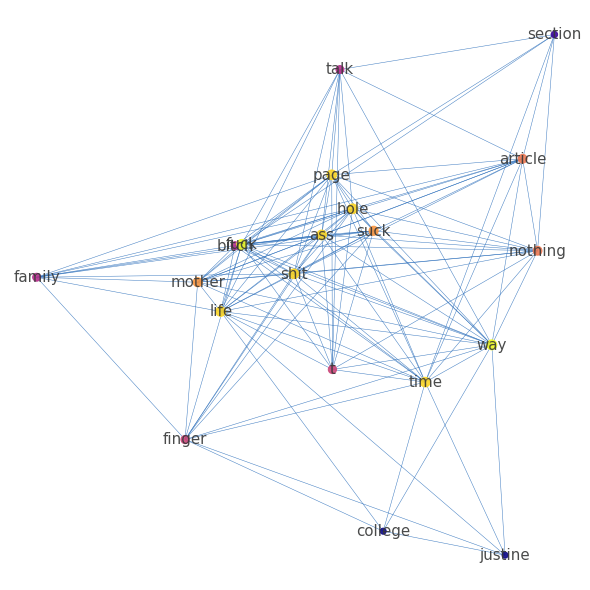

In [384]:
plt.rcParams['figure.figsize'] = (8,8)
insult_gNN_degree = nx.degree_centrality(insult_gNN_filtered)
insult_gNN_maxC = max(insult_gNN_degree.items(), key = lambda x : x[1])[1]
nx.draw(insult_gNN_filtered, 
        pos = nx.spring_layout(insult_gNN_filtered, weight='weight', iterations= 100), 
        labels = {n: n for n in insult_gNN_filtered.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [insult_gNN_degree[n] / insult_gNN_maxC for n in insult_gNN_filtered.nodes],
        node_size = [insult_gNN_degree[n] / insult_gNN_maxC * 100 for n in insult_gNN_filtered.nodes],
        font_size = 15,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [385]:
noninsult_gNN_filtered = filterWords(noninsult_gNN, minWeight=3, filter_='degree', rule='number', value_of_rule=20)
print(nx.info(noninsult_gNN_filtered))

Total number of nodes(after filtering) in the graph is 20
Name: 
Type: Graph
Number of nodes: 20
Number of edges: 192
Average degree:  19.2000


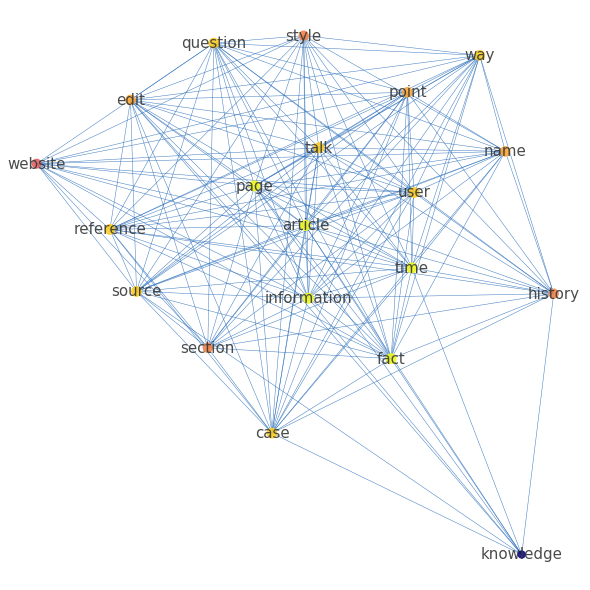

In [386]:
plt.rcParams['figure.figsize'] = (8,8)
noninsult_gNN_degree = nx.degree_centrality(noninsult_gNN_filtered)
noninsult_gNN_maxC = max(noninsult_gNN_degree.items(), key = lambda x : x[1])[1]
nx.draw(noninsult_gNN_filtered, 
        pos = nx.spring_layout(noninsult_gNN_filtered, weight='weight', iterations= 100), 
        labels = {n: n for n in noninsult_gNN_filtered.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [noninsult_gNN_degree[n] / noninsult_gNN_maxC for n in noninsult_gNN_filtered.nodes],
        node_size = [noninsult_gNN_degree[n] / noninsult_gNN_maxC * 100 for n in noninsult_gNN_filtered.nodes],
        font_size = 15,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

From these two network graph of noun networks, it is clear to see the difference between the insulting and non-insulting comment networs. The central nouns of insulting comments are majorly associated with dirty meanings while those of non-insulting comments are not.  

In [387]:
insult_gVN_filtered = filterWords(insult_gVN, minWeight=3, filter_='degree', rule='number', value_of_rule = 50)
print(nx.info(insult_gVN_filtered))

Total number of nodes(after filtering) in the graph is 50
Name: 
Type: Graph
Number of nodes: 50
Number of edges: 771
Average degree:  30.8400


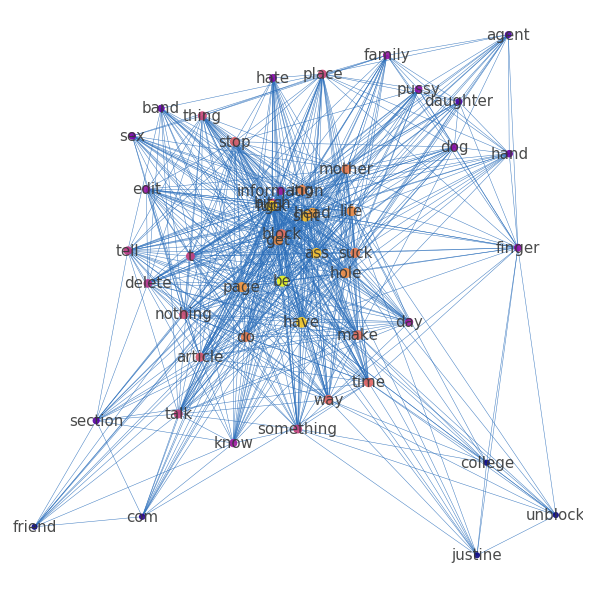

In [388]:
plt.rcParams['figure.figsize'] = (8,8)
insult_gVN_degree = nx.degree_centrality(insult_gVN_filtered)
insult_gVN_maxC = max(insult_gVN_degree.items(), key = lambda x : x[1])[1]
nx.draw(insult_gVN_filtered, 
        pos = nx.spring_layout(insult_gVN_filtered, weight='weight', iterations= 100), 
        labels = {n: n for n in insult_gVN_filtered.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [insult_gVN_degree[n] / insult_gVN_maxC for n in insult_gVN_filtered.nodes],
        node_size = [insult_gVN_degree[n] / insult_gVN_maxC * 100 for n in insult_gVN_filtered.nodes],
        font_size = 15,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [389]:
noninsult_gVN_filtered = filterWords(noninsult_gVN, minWeight=3, filter_='degree', rule='number', value_of_rule=50)
print(nx.info(noninsult_gVN_filtered))

Total number of nodes(after filtering) in the graph is 50
Name: 
Type: Graph
Number of nodes: 50
Number of edges: 1139
Average degree:  45.5600


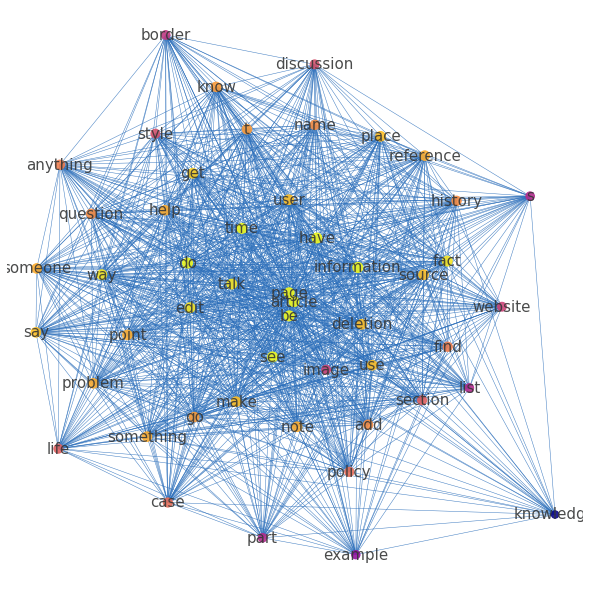

In [390]:
plt.rcParams['figure.figsize'] = (8,8)
noninsult_gVN_degree = nx.degree_centrality(noninsult_gVN_filtered)
noninsult_gVN_maxC = max(noninsult_gVN_degree.items(), key = lambda x : x[1])[1]
nx.draw(noninsult_gVN_filtered, 
        pos = nx.spring_layout(noninsult_gVN_filtered, weight='weight', iterations= 100), 
        labels = {n: n for n in noninsult_gVN_filtered.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [noninsult_gVN_degree[n] / noninsult_gVN_maxC for n in noninsult_gVN_filtered.nodes],
        node_size = [noninsult_gVN_degree[n] / noninsult_gVN_maxC * 100 for n in noninsult_gVN_filtered.nodes],
        font_size = 15,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [391]:
insult_gNJ_filtered = filterWords(insult_gNJ, minWeight=3, filter_='degree', rule='number', value_of_rule = 50)
print(nx.info(insult_gNJ_filtered))

Total number of nodes(after filtering) in the graph is 50
Name: 
Type: Graph
Number of nodes: 50
Number of edges: 651
Average degree:  26.0400


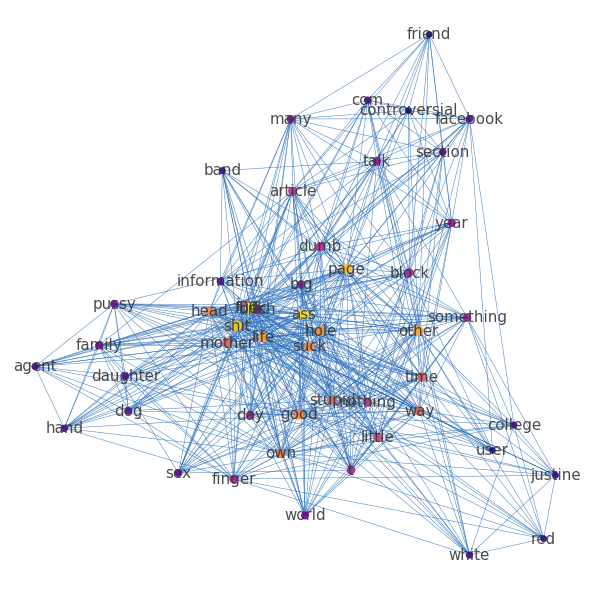

In [392]:
plt.rcParams['figure.figsize'] = (8,8)
insult_gNJ_degree = nx.degree_centrality(insult_gNJ_filtered)
insult_gNJ_maxC = max(insult_gNJ_degree.items(), key = lambda x : x[1])[1]
nx.draw(insult_gNJ_filtered, 
        pos = nx.spring_layout(insult_gNJ_filtered, weight='weight', iterations= 100), 
        labels = {n: n for n in insult_gNJ_filtered.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [insult_gNJ_degree[n] / insult_gNJ_maxC for n in insult_gNJ_filtered.nodes],
        node_size = [insult_gNJ_degree[n] / insult_gNJ_maxC * 100 for n in insult_gNJ_filtered.nodes],
        font_size = 15,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [393]:
noninsult_gNJ_filtered = filterWords(noninsult_gNJ, minWeight=3, filter_='degree', rule='number', value_of_rule = 50)
print(nx.info(noninsult_gNJ_filtered))

Total number of nodes(after filtering) in the graph is 50
Name: 
Type: Graph
Number of nodes: 50
Number of edges: 1074
Average degree:  42.9600


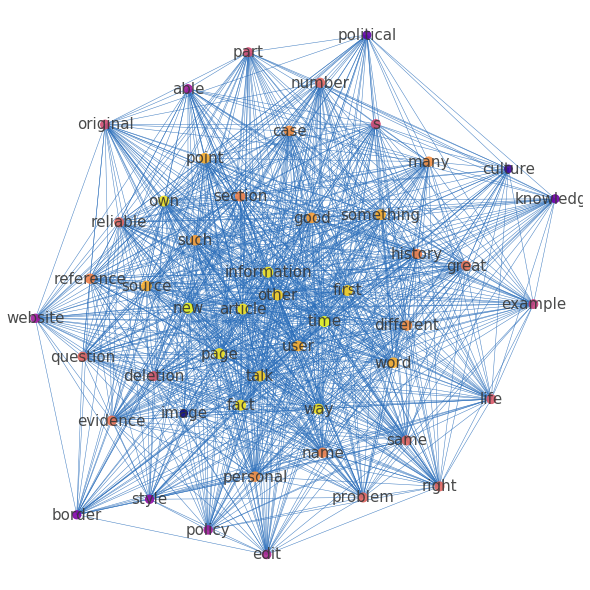

In [394]:
plt.rcParams['figure.figsize'] = (8,8)
noninsult_gNJ_degree = nx.degree_centrality(noninsult_gNJ_filtered)
noninsult_gNJ_maxC = max(noninsult_gNJ_degree.items(), key = lambda x : x[1])[1]
nx.draw(noninsult_gNJ_filtered, 
        pos = nx.spring_layout(noninsult_gNJ_filtered, weight='weight', iterations= 100), 
        labels = {n: n for n in noninsult_gNJ_filtered.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [noninsult_gNJ_degree[n] / noninsult_gNJ_maxC for n in noninsult_gNJ_filtered.nodes],
        node_size = [noninsult_gNJ_degree[n] / noninsult_gNJ_maxC * 100 for n in noninsult_gNJ_filtered.nodes],
        font_size = 15,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

From above comparisons, we can see that the words in insulting comments are more centralized than words in non-insulting comments. This means that in insulting comments, more words are likely to occur around those keywords (usually the dirty words) to form insulting meanings. Also, nouns are more likely to become central words in non-insulting comments than in insulting comments.   

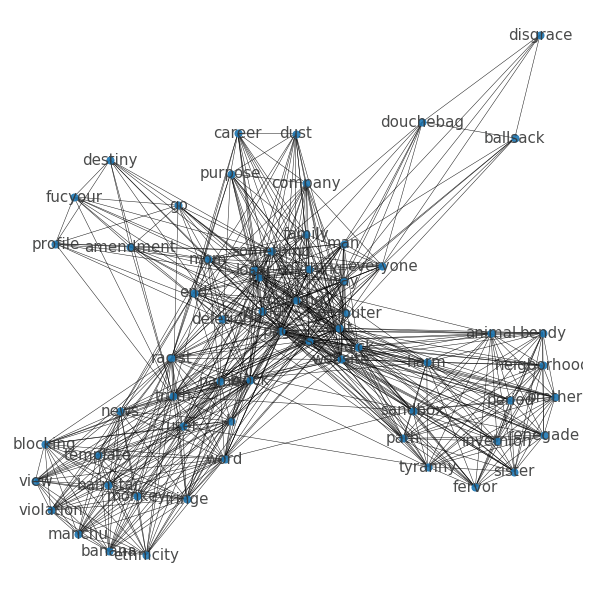

In [395]:
# "ego-networks" use the word wikipedia as the initial word
wikipedia_g1 = insult_gNN.subgraph(insult_gNN['wikipedia'])
nx.draw(wikipedia_g1, 
        pos = nx.spring_layout(wikipedia_g1, weight='weight', iterations= 100), 
        labels = {n: n for n in wikipedia_g1.nodes()},
        alpha = .9, 
        width = .5,
        node_size = 50,
        font_size = 15,
        font_color = 'xkcd:dark grey',
        cmap = plt.get_cmap('plasma'),
       )

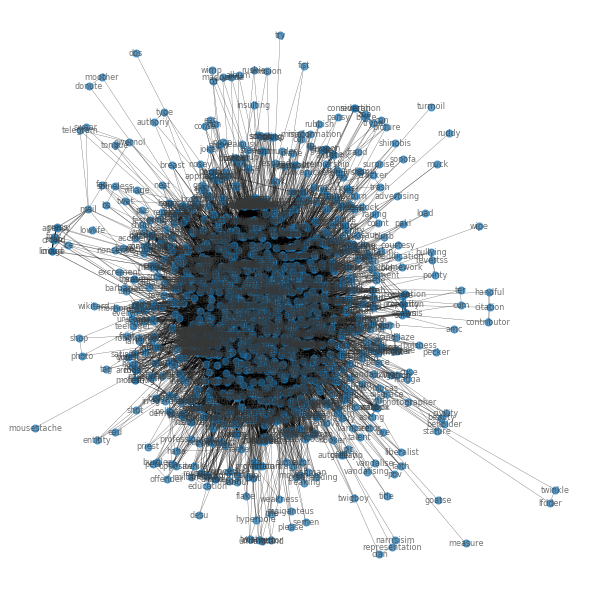

In [397]:
insult_g2_nodes = wikipedia_g1.nodes()
for n in wikipedia_g1.nodes():
    insult_g2_nodes |= set(insult_gNN[n])
wikipedia_g2 = insult_gNN.subgraph(insult_g2_nodes)
nx.draw(wikipedia_g2, 
        pos = nx.spring_layout(wikipedia_g2, weight='weight', iterations= 100), 
        labels = {n: n for n in wikipedia_g2.nodes()},
        alpha = .7, 
        width = .3,
        node_size = 50,
        font_size = 8,
        font_color = 'xkcd:dark grey',
        cmap = plt.get_cmap('plasma'),
       )

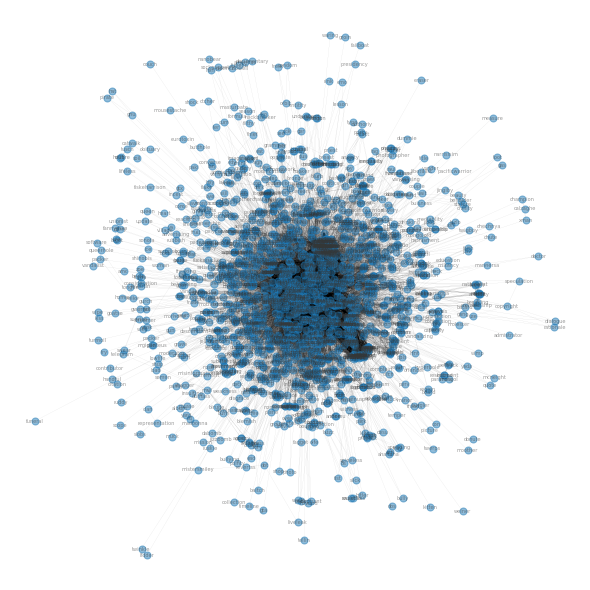

In [398]:
insult_g3_nodes = wikipedia_g2.nodes()
for n in wikipedia_g2.nodes():
    insult_g3_nodes |= set(insult_gNN[n])
wikipedia_g3 = insult_gNN.subgraph(insult_g3_nodes)
nx.draw(wikipedia_g3, 
        pos = nx.spring_layout(wikipedia_g3, weight='weight', iterations= 100), 
        labels = {n: n for n in wikipedia_g3.nodes()},
        alpha = .5, 
        width = .05,
        node_size = 50,
        font_size = 5,
        font_color = 'xkcd:dark grey',
        cmap = plt.get_cmap('plasma'),
       )

The word wikipedia is a surprising word occured in the insulting comments with high degree centrality, so I plot the network of this word to see its neighbor structure. We can see the neighbors start from words that are not so insulting, gradually spreading to most words in the noun network. There are two possibilities for this situation to happen: 
 1. The comments containing 'wikipedia' are not actually all insulting, but the words around it also occurs in insulting comments, making it a 'central' word in the insulting noun network. 
 2. The comments containing 'wikipedia' are indeed insulting, but are also without dirty words. Words like "tyranny", "racist" might produce insulting meanings in a more sophisticated way.  

## Creating networks of agents from corpora

Now that we have an idea of how we can use networks in python (a useful skill to know!), let us see how we can now use our knowledge of networks on extracting actors from corpora and building relations from them. Let us use the soap opera corpus now. 

In the last notebook we wrote methods to load corpora - this has been added to lucem_illud_2020.
The code returns a dictionary with each id mapping to the text associated with it. 

We would then use the source file to create the dataframe with the data - since this varies for each corpora, there is no built in function, but would follow a similar process.

This function might take some time.

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"

In [ ]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

We now use the source to see how the data is stored. Note that this is different from the movies corpus, and that we will need to use a different aggregating method to store the data. Each dataset would have a different approach, but they are all very similar, it depends on how the data is stored. Here multiple textids match multiple scripts, so our soap dataframe would be structured a little differently. 

You can see the first 20 lines of the source file here.

In [ ]:
import zipfile

In [ ]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
source[0:20]

In [ ]:
import pandas as pd

In [ ]:
soap_dict = {}

In [ ]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [ ]:
soap_dict.keys()

In [ ]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [ ]:
i = 0

In [ ]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

In [ ]:
soap_df

We now have each Soap, and each of the Tokenized texts. Let us see what kind of information we can get. These are American soap operas, and are likely to be cheesy and dramatic (an understatment). A fun start would be to make networks of each of the actors and actresses in these soaps. 

What would be a good way to create a network? Maybe everytime someone talks to someone we add one weight? But we wouldn't want to add weights whenever it's a different scene - or maybe we do? Let us look at the text and figure it out.

Note that we didn't add the year here because it spans over multiple years. If we are doing different kinds of analysis we would want to a years column as well.

In my dataframe, Days of Our Lives is the 9th corpora, and I conducted my basic analysis on that.

In [ ]:
dool = soap_df['Tokenized Texts'][3]

In [ ]:
' '.join(dool[0:1500])

Hmmm... we can't do our normal text processing. But this provides us with an interesting oppurtunity: every '@!' is followed by some useeful information. Let us do a quick check of how many characters exist here, and how many times they speak.

In [ ]:
characters = {}

In [ ]:
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1


In [ ]:
len(characters)

Wow, that's a lot of characters: but we notice a '@!' between certain actions too, such as screaming and sobbing. Let us maybe only look for characters with a high number of appearances?

In [ ]:
for character in characters:
    if characters[character] > 2000:
        print(character, characters[character])

Let's check these folks out on the interwebz...a image of search of the name + "days of our lives":

In [ ]:
Image(filename='../data/dool/dool_john.png') 

In [ ]:
Image(filename='../data/dool/dool_brady.jpg') 

In [ ]:
Image(filename='../data/dool/dool_hope.jpeg')

In [ ]:
# Image(filename='../data/dool/dool_philip.jpeg')

In [ ]:
# Image(filename='../data/dool/dool_marlena.jpg')

In [ ]:
Image(filename='../data/dool/dool_kate.png')

In [ ]:
Image(filename='../data/dool/dool_bo.png')

In [ ]:
Image(filename='../data/dool/dool_chloe.jpg')

In [ ]:
# Image(filename='../data/dool/dool_sami.jpg')

In [ ]:
Image(filename='../data/dool/dool_shawn.jpg')

In [ ]:
Image(filename='../data/dool/dool_belle.jpg')

In [ ]:
Image(filename='../data/dool/dool_lucas.jpg')

In [ ]:
Image(filename='../data/dool/dool_nicole.jpg')

These are definitely big, long-time players in the dramatic Days narrative. It would make sense to create a graph where each character who appears over 2000 times is a node, and each time they talk to each other, we add one to their weight. We should also store all the things these chracters say: that's useful information.

So we now iterate through the tokens in a manner where we can capture this information.

In [ ]:
actor_network = nx.Graph()

In [ ]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [ ]:
len(actor_network.nodes.data())

In [ ]:
actor_network.nodes.data()

In [ ]:
actor_network.nodes['Sami']['lines_spoken']

In [ ]:
i = 0

The following lines of code creates the graph. Please carefully go through the code: you should be able to understand (more or less) what is going on here. 

In [ ]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [ ]:
import seaborn as sns

In [ ]:
L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(actor_network))

In [ ]:
c

### Finding structure in networks

We now have a lot of useful information: we have a graph of all the characters, with their relationships with other characters, as well as all the words they've said. We tried finding communities, but it seems like everyone is connected to everyone: each of them form their own 'community'. Seems like people talk to each other a bunch in soaps.

This is however, not the best network to find any meaningful patterns, as we can see with everyone connected to everyone. But as we can see with our heatmap, not everyone talks to everyone an equal amount. How about we only keep our "important" ties, where people are talking to each other a lot?

In [ ]:
smaller_actor_network = nx.Graph()

In [ ]:
for actor_1 in actor_network.nodes():
    smaller_actor_network.add_node(actor_1, lines_spoken= actor_network.nodes[actor_1]['lines_spoken'], words=actor_network.nodes[actor_1]['words'])
    for actor_2 in actor_network.nodes():
        if actor_2!=actor_1 and actor_network.edges[(actor_1, actor_2)]['weight'] > 250:
            smaller_actor_network.add_edge(actor_1, actor_2, weight=actor_network.edges[(actor_1, actor_2)]['weight'])


In [ ]:
nx.draw(smaller_actor_network, with_labels=True, font_weight='bold')

This is a lot more interesting: while the sets of characters overlap, there is still two distinct communities if you look at characters who regularly talk to each other!

Let us see what our centrality measures look like, as well as communities.

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(smaller_actor_network))

In [ ]:
c

In [ ]:
dcentralities = nx.degree_centrality(smaller_actor_network)

In [ ]:
dcentralities['John'], dcentralities['Philip']

Our two different communities show up as detected by the networkx algorithm, and when we look at centralities, we can see that John is a lot more central than Philip.

Let us go back to our original graph, and see if the weight or number of similar appearences matches the text... how do we do this? Well, we already have the graph, and we also have information of who spoke to who. So we have our framework!

This means we can explore ideas contained in two of the papers you will be reading: . “No country for old members: User lifecycle and linguistic change in online communities.”, and  “Fitting In or Standing Out? The Tradeoffs of Structural and Cultural Embeddedness”, both of which you can access on Canvas. 

Let us use a simplified version of the papers, and check if a higher number of conversations might lead to a higher similarity between the word distributions for two characters. We can use the same divergences we used in the last notebook. Do you think it will match with the number of times each character was associated with each other?

In [399]:
import nltk

In [400]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [ ]:
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentence in actor_network.nodes[character]['words']:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud_2020.normalizeTokens(character_words))

In [ ]:
L = []

In [ ]:
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)

In [ ]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [ ]:
# np.corrcoef(M_, M)[0]

With our two heatplots, we can attempt to do some rudimentary analysis. We can see from our previous plot that Shawn and Belle talk to each other a lot, so do Hope and Bo, and Nicole and Brady, and Lucas and Sami. Do they also talk *like* each other?

Kind of, actually: all four of these pairs have a lower distance between them. Now I don't know anything about this particular soap... are these four pairs related? Are they in a relationship, either married or dating, or are they just really good friends?

This lays out the frameworks which you can now use to explore your own networks. 

# Interactional influence

In a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf), the authors develop a method to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network. Here we walk through this method, which relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [118]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [119]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [120]:
df_meta_info = pandas.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pandas.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pandas.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pandas.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pandas.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Juror 8': 0,
 'Juror 3': 1,
 'Juror 10': 2,
 'Foreman': 3,
 'Juror 7': 4,
 'Juror 4': 5,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 6': 8,
 'Juror 2': 9,
 'Juror 9': 10,
 'Juror 5': 11}

In [117]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

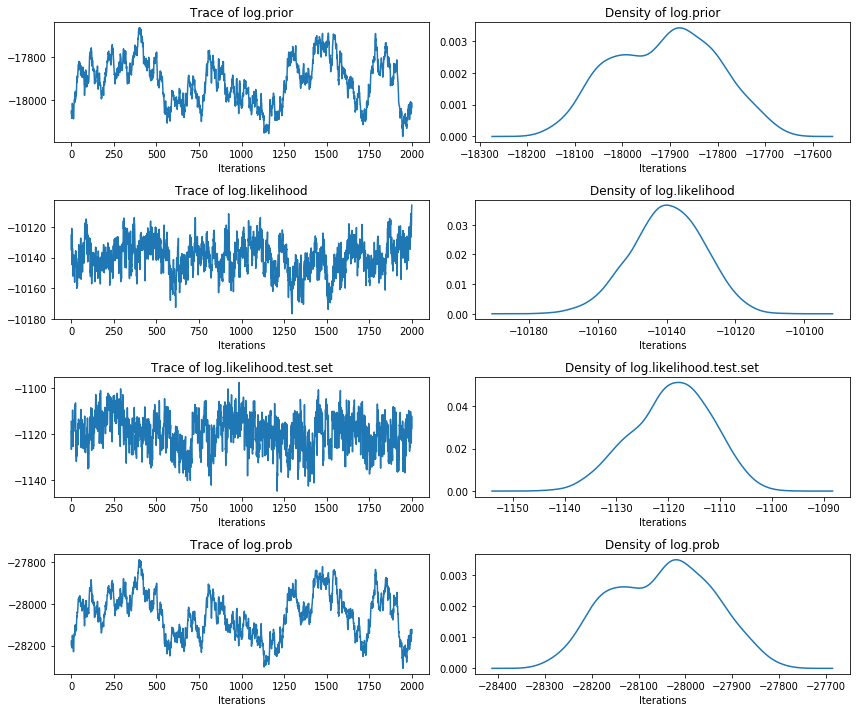

In [121]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [126]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [127]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pandas.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [128]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [129]:
df_mean

_goonaa_u  smile_doll_22  sofia_aguilar___  \
_goonaa_u                 0.000000       3.757957          8.089079   
smile_doll_22             8.529312       0.000000          6.673916   
sofia_aguilar___          8.413188       7.427932          0.000000   
zizigolo108               1.137060       0.612615          1.945196   
parham1994i               2.603853       5.901169          0.648844   
alpacino19935             5.791320       0.200669          0.266484   
__myrzabek0va_            0.378515       0.544628          0.779340   
jytrgvuu                  5.961338       0.695831          0.519459   
le.onid1216               4.526244       0.923784          0.503503   
j.c.romeo                 0.583732       2.303417          0.529583   
sajimkhan.sajimkhan.545   1.216641       1.281288          0.967587   
iamnadeyasarai            0.552951       1.001575          0.696393   

                         zizigolo108  parham1994i  alpacino19935  \
_goonaa_u                   0.930180     5.167497       0.794645   
smile_doll_22               4.150076     2.534751       4.902852   
sofia_aguilar___            4.540236     3.216307       1.030049   
zizigolo108                 0.000000     1.521390       0.834870   
parham1994i                 1.969868     0.000000       1.110101   
alpacino19935               0.582956     0.094200       0.000000   
__myrzabek0va_              0.454645     0.290575       0.447512   
jytrgvuu                    1.253033     0.247939       0.162463   
le.onid1216                 1.049825     1.288920       0.451562   
j.c.romeo                   1.722894     2.005939       0.299311   
sajimkhan.sajimkhan.545     1.675483     1.657341       1.681338   
iamnadeyasarai              1.180245     1.180355       0.497265   

                         __myrzabek0va_  jytrgvuu  le.onid1216  j.c.romeo  \
_goonaa_u                      0.845335  1.336329     6.106684   0.916765   
smile_doll_22                  1.092571  0.509942     3.825015   3.861767   
sofia_aguilar___               1.004598  0.529232     2.426582   0.407460   
zizigolo108                    1.338554  3.230634     1.013511   3.534036   
parham1994i                    0.279870  0.608548     1.047693   2.910670   
alpacino19935                  3.347982  0.316963     0.300770   2.112033   
__myrzabek0va_                 0.000000  0.614536     0.821143   0.951222   
jytrgvuu                       0.388620  0.000000     2.500976   2.375977   
le.onid1216                    0.375776  0.904313     0.000000   2.861587   
j.c.romeo                      0.652302  1.623813     0.841376   0.000000   
sajimkhan.sajimkhan.545        0.623032  1.925996     1.907992   0.539666   
iamnadeyasarai                 0.786181  0.588822     0.724613   0.912616   

                         sajimkhan.sajimkhan.545  iamnadeyasarai  
_goonaa_u                               6.385205        7.300776  
smile_doll_22                           0.266426        1.561626  
sofia_aguilar___                        1.233599        0.885871  
zizigolo108                             1.311436        4.115411  
parham1994i                             1.619475        1.570038  
alpacino19935                           0.370973        0.673364  
__myrzabek0va_                          0.476986        0.844157  
jytrgvuu                                0.481394        0.834032  
le.onid1216                             0.905421        0.310822  
j.c.romeo                               1.691612        1.756225  
sajimkhan.sajimkhan.545                 0.000000        1.138934  
iamnadeyasarai                          1.224854        0.000000

MEAN of influence matrix (row=from, col=to)


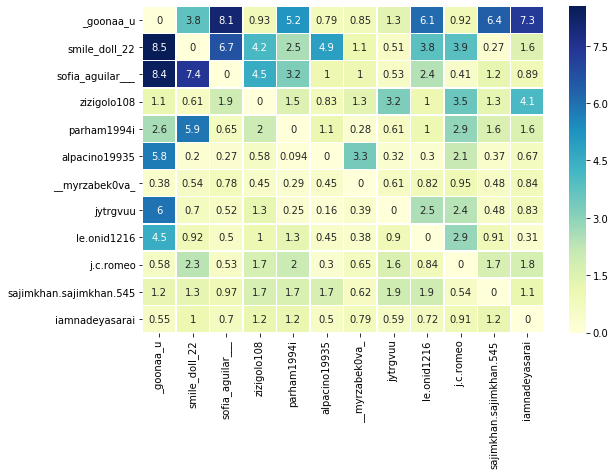

In [133]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


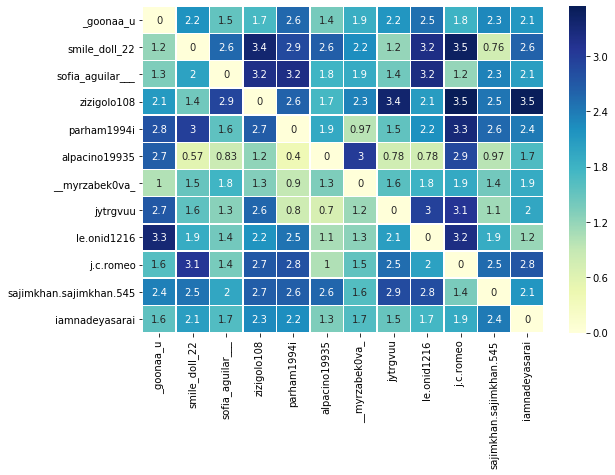

In [134]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [137]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

		Total linguistic influence sent/received 


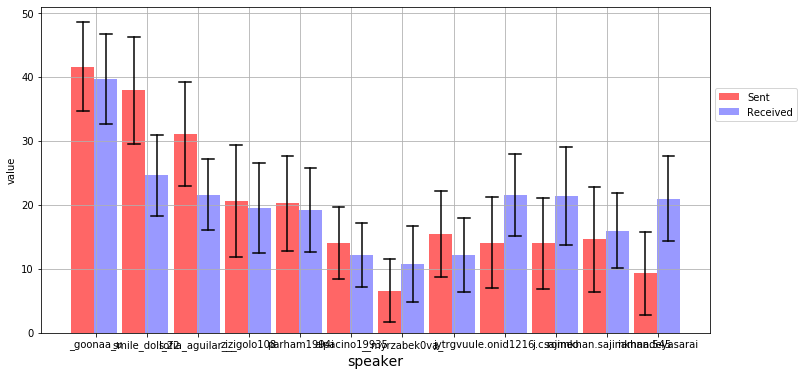

In [138]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [143]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [ ]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


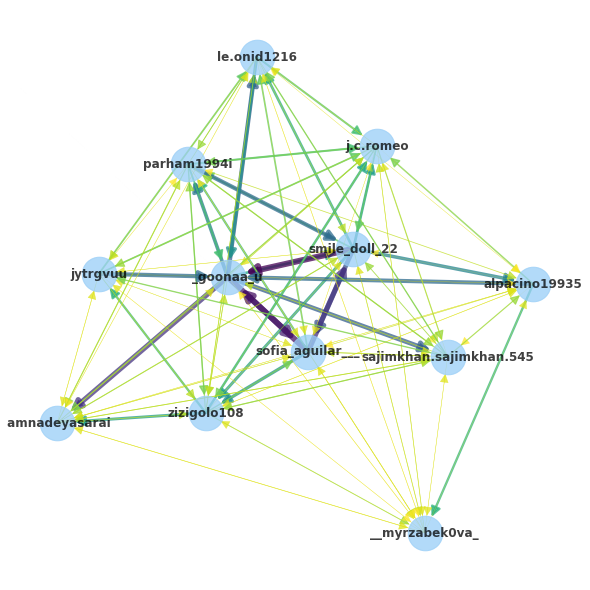

In [144]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

In [ ]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

In [ ]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [ ]:
import lucem_illud_2020
import pandas
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [ ]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

Transform data into TalkbankXML format:

In [ ]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud_2020.make_TalkbankXML(df_transcript, output_fname, language = language )

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [ ]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud_2020.bec_run(output_fname, Vocab_size, language, sampling_time)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project. Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<span style="color:red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<span style="color:red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

For this part, I would use a subset crawled from the IG websites, containing the most recent 20 posts from Justin Bieber and Selena Gomez, and following comments of these posts.  

In [17]:
IG_post_df = pandas.read_csv('HB_SG.csv')
IG_post_df

target                                               post  postID  \
0      selenagomez  Momma and I being tourists. We take great pict...       1   
1      selenagomez  Momma and I being tourists. We take great pict...       1   
2      selenagomez  Momma and I being tourists. We take great pict...       1   
3      selenagomez  Momma and I being tourists. We take great pict...       1   
4      selenagomez  Momma and I being tourists. We take great pict...       1   
...            ...                                                ...     ...   
3995  justinbieber  Exclusive at @applemusic a nature video for #h...      40   
3996  justinbieber  Exclusive at @applemusic a nature video for #h...      40   
3997  justinbieber  Exclusive at @applemusic a nature video for #h...      40   
3998  justinbieber  Exclusive at @applemusic a nature video for #h...      40   
3999  justinbieber  Exclusive at @applemusic a nature video for #h...      40   

                     post_time                    author  \
0     2020-02-25T16:30:46.000Z                rarebeauty   
1     2020-02-25T16:30:46.000Z                 tombachik   
2     2020-02-25T16:30:46.000Z             caro_franklin   
3     2020-02-25T16:30:46.000Z  diaryofafitmommyofficial   
4     2020-02-25T16:30:46.000Z                 lizgolden   
...                        ...                       ...   
3995  2020-03-03T14:58:29.000Z           adorkablejailey   
3996  2020-03-03T14:58:29.000Z           adorkablejailey   
3997  2020-03-03T14:58:29.000Z           rickthesizziler   
3998  2020-03-03T14:58:29.000Z            cutenessbieber   
3999  2020-03-03T14:58:29.000Z                 sorayanie   

                  comment_time  \
0     2020-02-25T16:32:08.000Z   
1     2020-02-25T21:20:49.000Z   
2     2020-02-25T16:37:46.000Z   
3     2020-02-25T16:31:48.000Z   
4     2020-02-25T16:53:03.000Z   
...                        ...   
3995  2020-03-03T15:00:49.000Z   
3996  2020-03-03T15:00:52.000Z   
3997  2020-03-03T15:00:54.000Z   
3998  2020-03-03T15:01:03.000Z   
3999  2020-03-03T15:01:04.000Z   

                                                comment  
0                                                   💕💕💕  
1                                                   💗💗💗  
2                                         😷😂 love this!  
3                                              So fun!!  
4                      THE LAST ONE - i’m toast. #DRAMA  
...                                                 ...  
3995                                 I LOVE YOU GOO GOO  
3996                                              💜💜💜💜💜  
3997                              it’s what you deserve  
3998  I want to watch it but i dont have a apple mus...  
3999  ❤️❤️❤️❤️❤️ Why u look better after u married! ...  

[4000 rows x 7 columns]

In [402]:
IG_post_g = nx.Graph()
IG_post_g.add_nodes_from(pandas.unique(IG_post_df['author']))

In [403]:
import itertools
post_groups = IG_post_df.groupby(['postID'])
author_groups = [(list(i[1]['target'])[0],pandas.unique(i[1]['author'])) for i in post_groups]
edge_groups = [(x,list(itertools.combinations(y,2))) for x,y in author_groups]

In [404]:
len(edge_groups)

40

In [405]:
for target, edge_group in edge_groups:
    for edge in edge_group:
        if edge not in IG_post_g.edges():
            IG_post_g.add_edge(edge[0], edge[1], weight=1, 
                               partial_weight={k:0 for k in pandas.unique(IG_post_df['target'])})
        else:
            IG_post_g.edges[edge]['weight'] += 1    
        IG_post_g.edges[edge]['partial_weight'][target] += 1

In [406]:
import copy
filtered_g = copy.deepcopy(IG_post_g) 

In [407]:
# filtering those speakers that only appear once
filtered_g.remove_edges_from([(n1, n2) for n1, n2, d in filtered_g.edges(data = True) if d['weight'] <= 1])
filtered_g.remove_nodes_from(list(nx.isolates(filtered_g)))

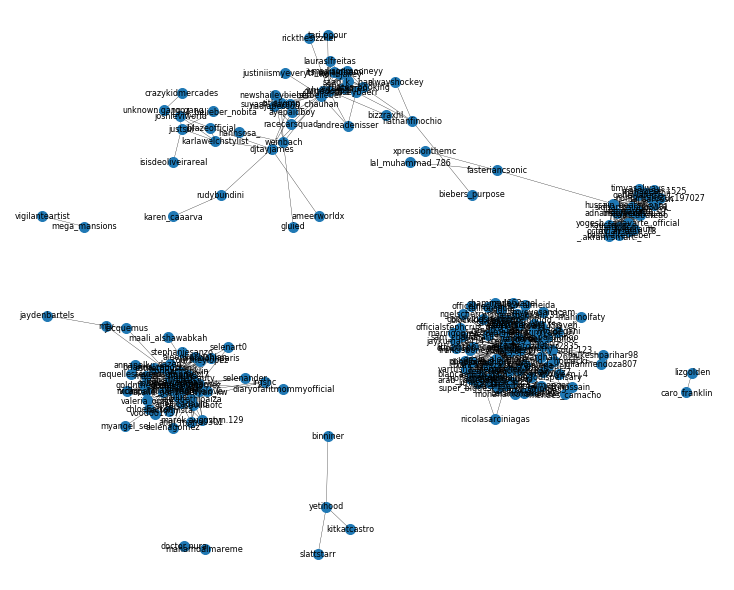

In [408]:
plt.rcParams['figure.figsize']=[10,8]
nx.draw(filtered_g, pos=nx.drawing.layout.spring_layout(filtered_g, k=0.2, weight='weight'),
        with_labels=True, width=0.3, node_size=100, font_size=8)

In [409]:
len(filtered_g.nodes)

203

In [410]:
from networkx.algorithms.community import greedy_modularity_communities
communities = greedy_modularity_communities(filtered_g)
print(len(communities))

9


In [411]:
for c in communities:
    print(len(c))

79
49
38
25
4
2
2
2
2


Interestingly, we see that the commentators formed nine non-trivial groups (at least comments on the same post twice) in the filtered network. Especially for the first four communities, the number of connected nodes is relatively large, we would like to dig deeper in the biggest community for further analysis.  

In [412]:
top_community = communities[:4]
top_gs = [nx.subgraph(IG_post_g,c) for c in top_community]
top_partial_weights = [[d['partial_weight'] for n1,n2,d in top_g.edges(data=True)] for top_g in top_gs]

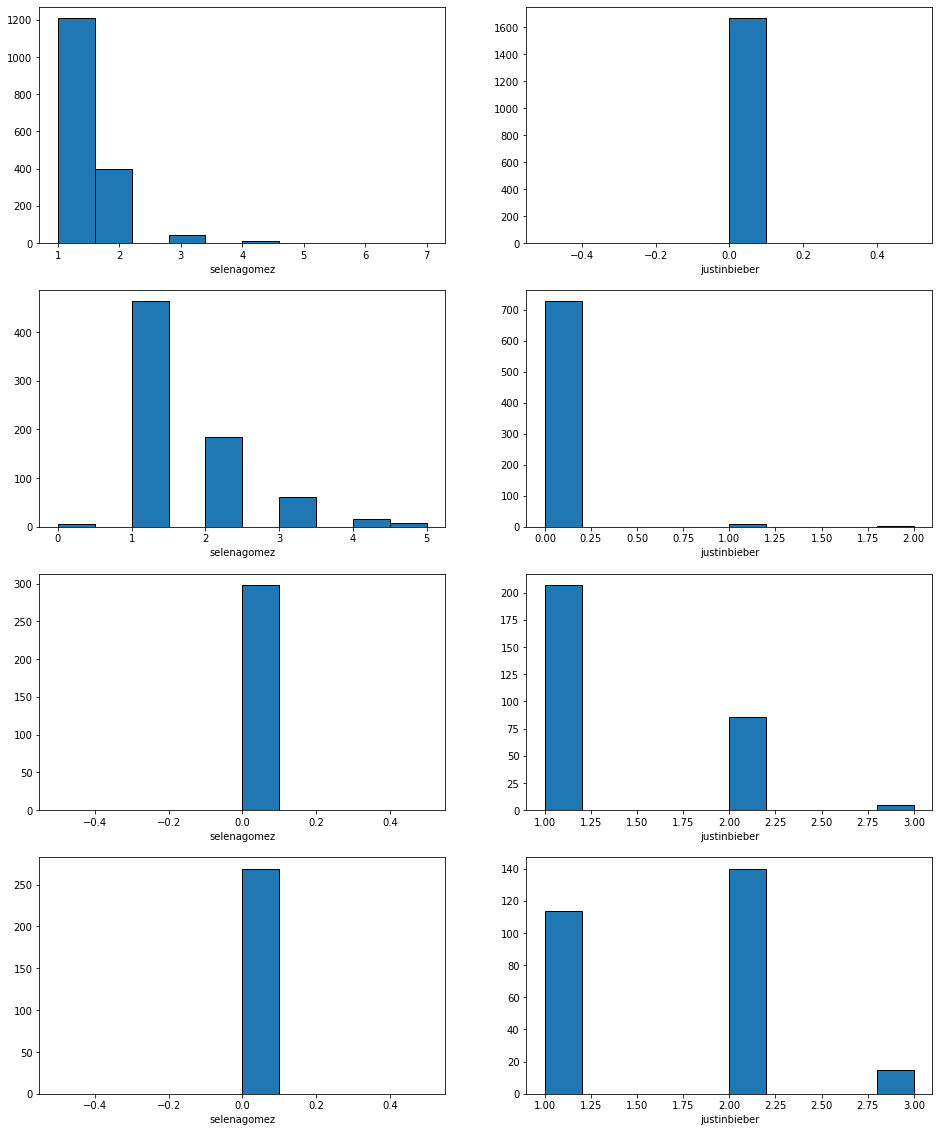

In [413]:
plt.rcParams['figure.figsize']=[16,20]
targets = pandas.unique(IG_post_df['target'])
fig, axes = plt.subplots(len(top_gs), len(targets))
for i in range(len(top_gs)):
    for j in range(len(targets)):
        axes[i, j].hist([d[targets[j]] for d in top_partial_weights[i]], edgecolor='k')
        axes[i, j].set_xlabel(targets[j])
plt.show()

From the above histogram, it can be seen that there are significant differences in the target celebrities commented by commenters in different communities. Commenters in community one and two are more likely to be followers of Selena, and community three and four are more likely to be followers of Bieber. Based on these four communities, it seems that commenters rarely co-comment on both of these two celebrities.

In [414]:
top_dcentralities = [sorted(nx.degree_centrality(g).items(), key=lambda x:x[1], reverse=True)[:10] for g in top_gs]
top_dcentralities

[[('aina_.23', 1.0),
  ('_fleur.t_', 0.9615384615384615),
  ('erolaliyef777', 0.8974358974358974),
  ('jamie_reacher', 0.8333333333333333),
  ('jojo_fashion_.dz', 0.8076923076923077),
  ('arcila_alejandra', 0.782051282051282),
  ('vab2_0_2_0', 0.782051282051282),
  ('nando_4568', 0.7692307692307692),
  ('runooooe', 0.7564102564102564),
  ('cedriclamountbrown', 0.7435897435897436)],
 [('disneylandgomez', 0.9583333333333333),
  ('dehalvesreal', 0.9375),
  ('connarfranklin', 0.8958333333333333),
  ('estherhouston', 0.8958333333333333),
  ('shholln', 0.875),
  ('real_ali_shah', 0.875),
  ('maxehrich', 0.875),
  ('videosofgomez', 0.875),
  ('sexlikeselena', 0.8541666666666666),
  ('tombachik', 0.8333333333333333)],
 [('whycuespg', 0.8108108108108109),
  ('sfsbelieber', 0.7567567567567568),
  ('caseybaerr', 0.7297297297297298),
  ('lauraslfreitas', 0.6756756756756757),
  ('rickthesizziler', 0.6216216216216217),
  ('djtayjames', 0.5945945945945946),
  ('andreadenisser', 0.5675675675675675),
 

When we examine the max degree centralities in each networks, we see that the first and the fourth community has very high 
max degree centralities, but they still have great difference. For community one, it is likely that the node "aina_.23" have co-comment on Selena's posts with other nodes while other nodes do not co-comment as much. But for community four, the distribtion of degree is more even among all the nodes. 

In [415]:
# find the nodes that have made comments on both celebrities
import functools
target_groups = IG_post_df.groupby(['target'])
both_nodes = functools.reduce(lambda x,y: set(x[1])&set(y[1]), list(target_groups['author']))
list(both_nodes)

['rudybundini',
 'elizabethloaiza',
 'estherhouston',
 'jacquemus',
 'valeria_orsini',
 'chloehamilton23',
 'mtv',
 'wowartsz',
 'liyanajasmay',
 'lllireinhart']

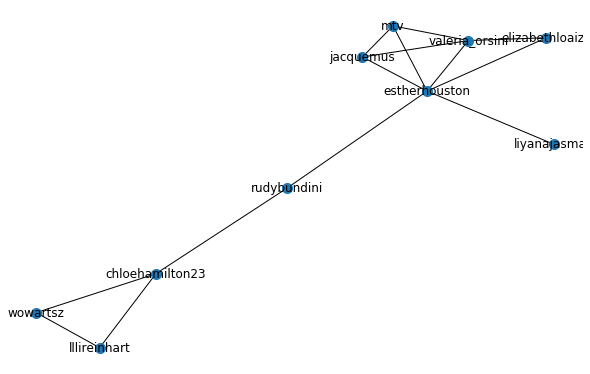

In [416]:
plt.rcParams['figure.figsize']=[8,5]
both_g = IG_post_g.subgraph(both_nodes)
nx.draw(both_g, with_labels=True, node_size=100, font_size=12)

First, I would like to see these ten commenters' divergence degree towards the same target celebrities.

In [417]:
both_df = IG_post_df.loc[IG_post_df['author'].isin(both_nodes)]
SG_df = both_df.loc[IG_post_df['target'] == 'selenagomez']
JB_df = both_df.loc[IG_post_df['target'] == 'justinbieber']

In [418]:
SG_individual = [lucem_illud_2020.normalizeTokens(" ".join(item[1]['comment'])) \
                 for item in list(SG_df.groupby(['author']))]
JB_individual = [lucem_illud_2020.normalizeTokens(" ".join(item[1]['comment'])) \
                 for item in list(JB_df.groupby(['author']))]

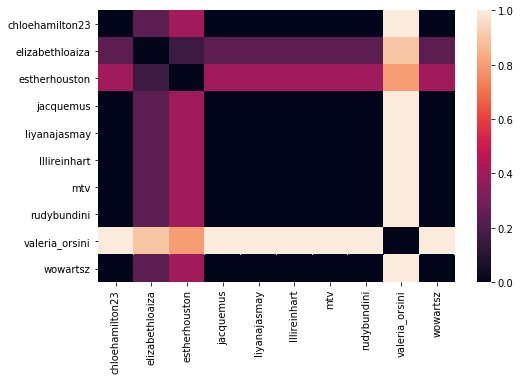

In [419]:
import seaborn as sns
from orderedset import OrderedSet

SG_L = []
for p in SG_individual:
    row = []
    for q in SG_individual:
        row.append(Divergence(p,q, difference='KS'))
    SG_L.append(row)
SG_fig = plt.figure()
SG_div = pandas.DataFrame(np.array(SG_L), columns = [item[0] for item in list(SG_df.groupby(['author']))], 
                          index = [item[0] for item in list(SG_df.groupby(['author']))])
SG_ax = sns.heatmap(SG_div)
plt.show()

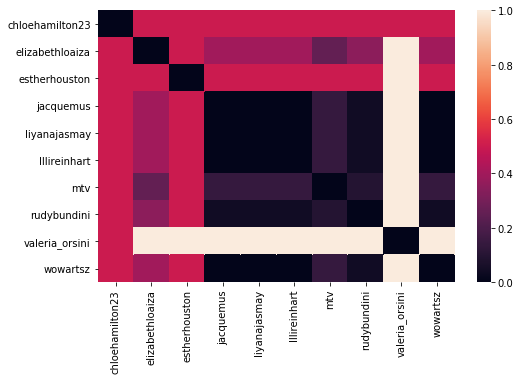

In [420]:
JB_L = []
for p in JB_individual:
    row = []
    for q in JB_individual:
        row.append(Divergence(p,q, difference='KS'))
    JB_L.append(row)
JB_fig = plt.figure()
JB_div = pandas.DataFrame(np.array(JB_L), columns = [item[0] for item in list(JB_df.groupby(['author']))], 
                          index = [item[0] for item in list(JB_df.groupby(['author']))])
JB_ax = sns.heatmap(JB_div)
plt.show()

Interestingly, we found that the IG comments towards the same celebrities have great similarity. In those comments of Selena Gomez's post, some users even exactly used some of the same words as others. Also, another reason is that many users use emojis to present their comments, which increase the possibility of making identical comments than using pure text. 

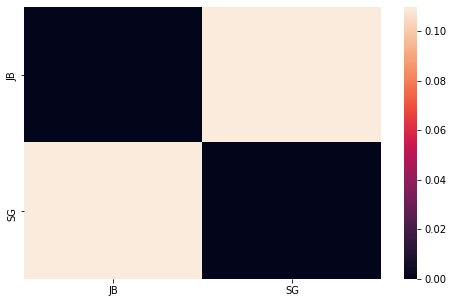

In [421]:
import itertools
SG_JB = [list(itertools.chain(*x)) for x in (JB_individual, SG_individual)]
compare_L = []
for p in SG_JB:
    row = []
    for q in SG_JB:
        row.append(Divergence(p,q, difference='KS'))
    compare_L.append(row)
compare_fig = plt.figure()
compare_div = pandas.DataFrame(np.array(compare_L), columns = ['JB','SG'], index =  ['JB','SG'])
compare_ax = sns.heatmap(compare_div)
plt.show()

The result above shows the difference between comment words towards these two celebrities. It suggests that they are quite different, however, only this two celebrities might not give us many interesting insights. In the final project more dimensions would be examined.

### Interactional influence

For this part, I think it is useful to choose some of my post-comments data to check. These data are prodeuced in a comment chain, which is suitable for time-related analysis. Here we just set up the time unit to be seconds. For each time of comments, we assume that the time span would be one minute 60 seconds.

In [109]:
import time,datetime
IG_influence_df = pandas.DataFrame(columns = ['name','tokens','start','end'])
IG_sample_13 = IG_post_df.loc[IG_post_df['postID']==13]
for i in IG_sample_13.index:
    name = IG_sample_13.loc[i,'author']
    tokens = [t for t in lucem_illud_2020.normalizeTokens(IG_sample_13.loc[i,'comment']) if t.encode('utf-8') != b'\xef\xb8\x8f']
    time = datetime.datetime.strptime(IG_sample_13.loc[i,'comment_time'].split('.')[0], "%Y-%m-%dT%H:%M:%S")    
    IG_influence_df.loc[len(IG_influence_df)]= [name, tokens, time, time]
IG_influence_df

name  \
0             alpacino19935   
1            __myrzabek0va_   
2              ayda12125004   
3                 _goonaa_u   
4   sajimkhan.sajimkhan.545   
..                      ...   
95               maringomez   
96        ibrokhim_inoyatov   
97        ibrokhim_inoyatov   
98        ibrokhim_inoyatov   
99        ibrokhim_inoyatov   

                                               tokens               start  \
0               [@brucelee, @selenagomez, love, 😍, 😍] 2020-03-04 11:00:33   
1                                     [❤, ❤, ❤, ❤, ❤] 2020-03-04 11:29:01   
2   [greek, prime, minister, prosecute, genocide, ... 2020-03-04 13:06:52   
3   [gang, gang, ❤, ❤, 💞, 💞, 💞, cutee, ❤, ❤, ❤, ❤,... 2020-03-04 13:55:50   
4                                        [👏, 😢, 🙌, 👏] 2020-03-04 16:20:08   
..                                                ...                 ...   
95                        [cute, ❤, ❤, ❤, ❤, 😘, ❤, 😘] 2020-02-28 20:54:14   
96                                             [🔥, 🔥] 2020-02-27 16:14:19   
97                                          [🔥, 🔥, 🔥] 2020-02-27 16:14:21   
98                                          [🔥, 🔥, 🔥] 2020-02-27 16:14:23   
99                                       [🔥, 🔥, 🔥, 🔥] 2020-02-27 16:14:24   

                   end  
0  2020-03-04 11:00:33  
1  2020-03-04 11:29:01  
2  2020-03-04 13:06:52  
3  2020-03-04 13:55:50  
4  2020-03-04 16:20:08  
..                 ...  
95 2020-02-28 20:54:14  
96 2020-02-27 16:14:19  
97 2020-02-27 16:14:21  
98 2020-02-27 16:14:23  
99 2020-02-27 16:14:24  

[100 rows x 4 columns]

In [110]:
# date conversion
min_date = min(IG_influence_df['start'])
IG_influence_df['start']=IG_influence_df['start'].apply(lambda x:(x-min_date).total_seconds())
IG_influence_df['end']=IG_influence_df['end'].apply(lambda x:(x-min_date).total_seconds())

In [111]:
# if only one time comment, we let the end of them increase 60 seconds by default
for i in range(len(IG_influence_df)):
    if IG_influence_df.loc[i, 'start'] == IG_influence_df.loc[i, 'end']:
        IG_influence_df.loc[i, 'end'] += 60
IG_influence_df

name  \
0             alpacino19935   
1            __myrzabek0va_   
2              ayda12125004   
3                 _goonaa_u   
4   sajimkhan.sajimkhan.545   
..                      ...   
95               maringomez   
96        ibrokhim_inoyatov   
97        ibrokhim_inoyatov   
98        ibrokhim_inoyatov   
99        ibrokhim_inoyatov   

                                               tokens     start       end  
0               [@brucelee, @selenagomez, love, 😍, 😍]  499574.0  499634.0  
1                                     [❤, ❤, ❤, ❤, ❤]  501282.0  501342.0  
2   [greek, prime, minister, prosecute, genocide, ...  507153.0  507213.0  
3   [gang, gang, ❤, ❤, 💞, 💞, 💞, cutee, ❤, ❤, ❤, ❤,...  510091.0  510151.0  
4                                        [👏, 😢, 🙌, 👏]  518749.0  518809.0  
..                                                ...       ...       ...  
95                        [cute, ❤, ❤, ❤, ❤, 😘, ❤, 😘]  103195.0  103255.0  
96                                             [🔥, 🔥]       0.0      60.0  
97                                          [🔥, 🔥, 🔥]       2.0      62.0  
98                                          [🔥, 🔥, 🔥]       4.0      64.0  
99                                       [🔥, 🔥, 🔥, 🔥]       5.0      65.0  

[100 rows x 4 columns]

In [116]:
# date transformation, to control the running time, only first ten comments are used.
lucem_illud_2020.make_TalkbankXML(IG_influence_df[:20], 'IG_influence.xml', language = 'eng')

New File saved to .\data\IG_influence\IG_influence.xml


0

In [125]:
# After running this from the command line, we get this final result. first check the table
result_path = "results/IG_influence/"
my_meta_info = pandas.read_table(result_path + 'meta-info.txt',header=None)
my_influence_df = pandas.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
my_participants_df = pandas.read_csv(result_path + 'cast.txt', delim_whitespace=True)
my_person_id = pandas.Series(my_participants_df['agent.num'].values-1,index=my_participants_df['agent.name']).to_dict()
my_person_id

{'_goonaa_u': 0,
 'smile_doll_22': 1,
 'sofia_aguilar___': 2,
 'zizigolo108': 3,
 'parham1994i': 4,
 'alpacino19935': 5,
 '__myrzabek0va_': 6,
 'jytrgvuu': 7,
 'le.onid1216': 8,
 'j.c.romeo': 9,
 'sajimkhan.sajimkhan.545': 10,
 'iamnadeyasarai': 11,
 'bangselbang': 12,
 'flop_s20': 13,
 'armani.group7': 14,
 'ayda12125004': 15}

In [132]:
# visualize the incluence matrix
my_id_person = {}
for p in my_person_id:
    my_id_person[person_id[p]]=p

my_mean_df = getmatrix(my_influence_df.mean(axis=0),len(my_person_id))
my_std_df = getmatrix(my_influence_df.std(axis=0),len(my_person_id))
my_mean_df

_goonaa_u  smile_doll_22  sofia_aguilar___  \
_goonaa_u                 0.000000       0.985254          0.101002   
smile_doll_22             0.402197       0.000000          0.540318   
sofia_aguilar___          0.987124       0.230458          0.000000   
zizigolo108               0.465996       0.942333          0.996758   
parham1994i               0.654182       1.288213          0.113930   
alpacino19935             0.200234       0.950211          1.243586   
__myrzabek0va_            4.447068       0.308456          1.300707   
jytrgvuu                  0.984162       0.925241          0.755758   
le.onid1216               0.764887       0.997412          0.990226   
j.c.romeo                 1.212066       0.743376          0.762668   
sajimkhan.sajimkhan.545   0.408563       0.524938          0.462603   
iamnadeyasarai            1.063939       0.801522          0.848888   
bangselbang               1.249700       1.377432          0.566849   
flop_s20                  0.442552       0.694854          0.727005   
armani.group7             0.952367       0.774649          0.943309   
ayda12125004              0.299858       0.648543          0.485852   

                         zizigolo108   parham1994i  alpacino19935  \
_goonaa_u                   0.682488  9.603191e-01       0.833997   
smile_doll_22               0.269961  1.018416e+00       0.772006   
sofia_aguilar___            0.649710  8.495628e-01       0.616765   
zizigolo108                 0.000000  3.749138e-01       1.023320   
parham1994i                 0.668167  0.000000e+00       0.587329   
alpacino19935               0.935081  3.474653e-01       0.000000   
__myrzabek0va_              0.838996  8.847297e-01       0.653265   
jytrgvuu                    0.880604  5.371137e-01       1.065044   
le.onid1216                 1.024074  1.293454e+00       1.262478   
j.c.romeo                   0.521082  8.418787e-01       0.312553   
sajimkhan.sajimkhan.545     0.884721  7.173013e-01       0.613044   
iamnadeyasarai              0.582947  8.805940e-01       0.391274   
bangselbang                 0.861036  5.070968e-01       0.498158   
flop_s20                    0.778301  1.048639e+00       0.938566   
armani.group7               0.871355  1.484634e-17       1.843512   
ayda12125004                1.185884  1.549221e+00       0.669745   

                         __myrzabek0va_  jytrgvuu  le.onid1216  j.c.romeo  \
_goonaa_u                      0.712595  1.863476     0.161949   0.081459   
smile_doll_22                  0.456183  0.664990     0.798885   1.113661   
sofia_aguilar___               0.731128  1.220022     3.548363   1.431281   
zizigolo108                    0.629594  0.896501     1.039398   1.473893   
parham1994i                    0.252527  1.265887     0.699293   0.613377   
alpacino19935                  0.708798  0.207470     0.836255   1.222822   
__myrzabek0va_                 0.000000  1.779626     0.248756   0.698285   
jytrgvuu                       0.918719  0.000000     0.778172   0.517146   
le.onid1216                    0.747498  0.888732     0.000000   0.253413   
j.c.romeo                      0.466140  0.403158     1.217899   0.000000   
sajimkhan.sajimkhan.545        0.584610  0.813733     0.631143   0.598589   
iamnadeyasarai                 0.400545  1.080534     0.507379   1.039780   
bangselbang                    1.280637  0.602203     0.758602   0.569923   
flop_s20                       0.681142  0.750982     1.027970   0.806054   
armani.group7                  0.735792  0.454112     0.298738   0.982806   
ayda12125004                   1.816741  1.008755     0.108301   0.829421   

                         sajimkhan.sajimkhan.545  iamnadeyasarai  bangselbang  \
_goonaa_u                               0.132275        0.781117     0.148324   
smile_doll_22                           0.454636        0.735321     0.536721   
sofia_aguilar___                        1.301246        0.504365     0.609488   
zizigolo1

MEAN of my influence matrix (row=from, col=to)


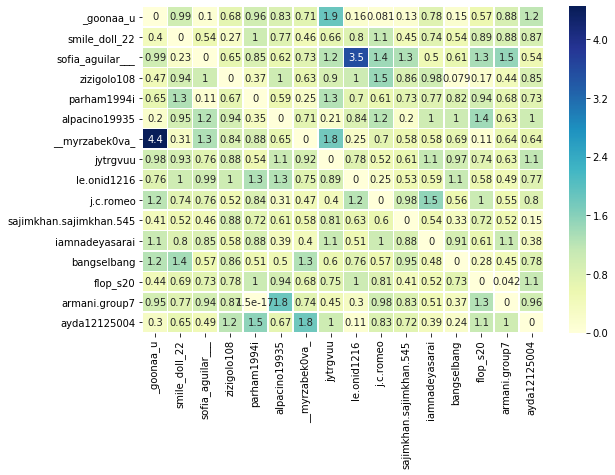

In [135]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(my_mean_df, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of my influence matrix (row=from, col=to)')
plt.show()

SD of my influence matrix (row=from, col=to)


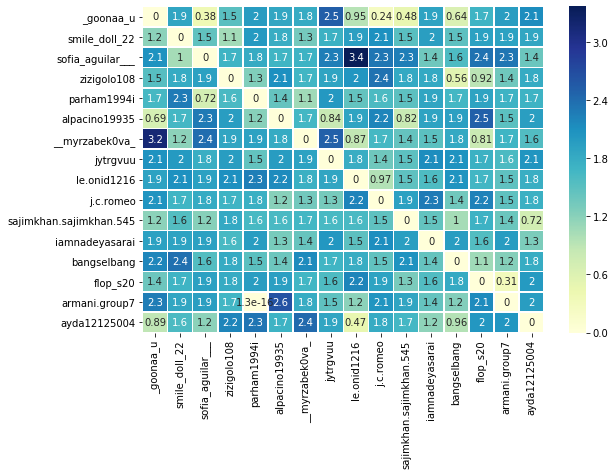

In [136]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(my_std_df, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of my influence matrix (row=from, col=to)')
plt.show()

Intuitively, the matrix of influence is asymmetric, meaning that while A could pose strong influence on B, but B might influence A to a minimal extent. Among the matrix, we see that the influence less than 1, which might related to the fact that many audiences do not comments concurrently. But still, some interactions like the one "\_\_myrzabek0va\_\_" to '\_goonaa\_u' seems relatively high. 

In [141]:
my_sender_std = {} #sd of total influence sent
my_reciever_std = {} #sd of total influence recieved
for i in range(len(my_person_id)):
    my_reciever_std[my_id_person[i]] = my_influence_df[my_influence_df.columns[i::len(my_person_id)]].sum(axis=1).std()
    my_sender_std[my_id_person[i]] = my_influence_df[my_influence_df.columns[i*len(my_person_id):(i+1)*len(my_person_id):]].sum(axis=1).std()

my_sent = my_mean_df.sum(axis=1) #mean of total influence sent
my_recieved = my_mean_df.sum(axis=0) #mean of total influence recieved

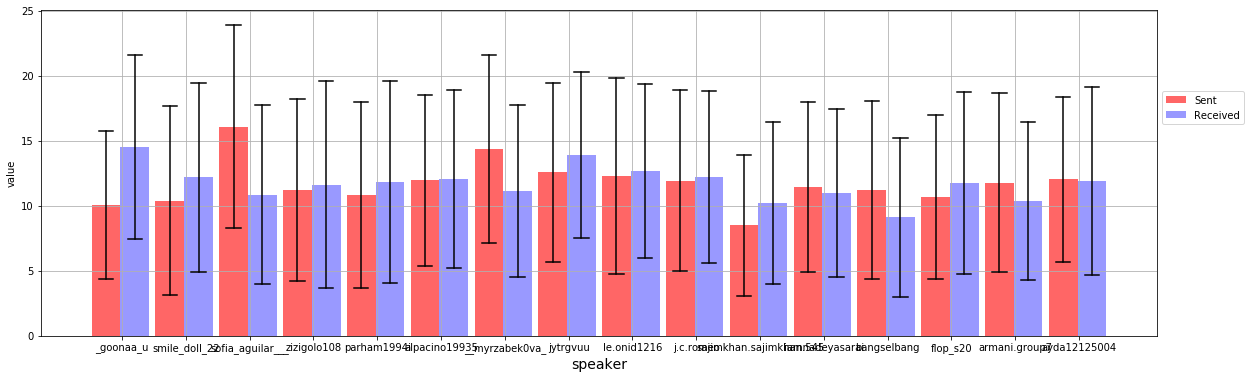

In [142]:
ax.fig = plt.figure(figsize=[20,6])

plt.grid()
wd=0.45
ii=0
for p in my_sender_std:
    plt.bar(my_person_id[p],my_sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([my_person_id[p]-wd/4,my_person_id[p]+wd/4],[my_sent.loc[p]+my_sender_std[p],my_sent.loc[p]+my_sender_std[p]],color='k')
    plt.plot([my_person_id[p]-wd/4,my_person_id[p]+wd/4],[my_sent.loc[p]-my_sender_std[p],my_sent.loc[p]-my_sender_std[p]],color='k')
    plt.plot([my_person_id[p],my_person_id[p]],[my_sent.loc[p]-my_sender_std[p],my_sent.loc[p]+my_sender_std[p]],color='k')
    ii+=1
ii=0
for p in my_reciever_std:
    plt.bar(my_person_id[p]+wd,my_recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([my_person_id[p]+wd-wd/4,my_person_id[p]+wd+wd/4],[my_recieved.loc[p]+my_reciever_std[p],my_recieved.loc[p]+my_reciever_std[p]],color='k')
    plt.plot([my_person_id[p]+wd-wd/4,my_person_id[p]+wd+wd/4],[my_recieved.loc[p]-my_reciever_std[p],my_recieved.loc[p]-my_reciever_std[p]],color='k')
    plt.plot([my_person_id[p]+wd,my_person_id[p]+wd],[my_recieved.loc[p]-my_reciever_std[p],my_recieved.loc[p]+my_reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(len(my_person_id))],list(zip(*sorted(my_id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

Most commenters in this sample have higher received values than set values, and the standard deviation is relatively large. Again, this could be related to the initial input where each user only make comments once instead of making some consecutive comments. 

IG Commenters Mean Influence Network


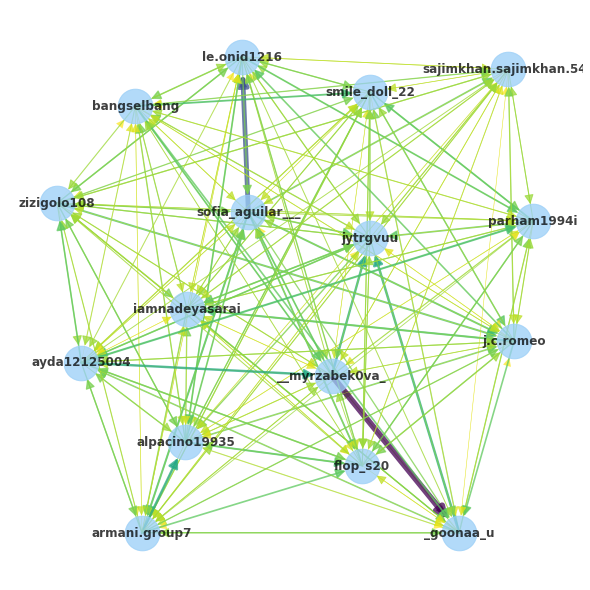

In [146]:
my_mean = drawNetwork(my_mean_df,'IG Commenters Mean Influence Network')